In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as sm
from tqdm import tqdm; tqdm.pandas();
from src.dag import grn
import pickle
import os
import scipy
import scipy.stats as ss
import itertools
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)
plt.rc('text', usetex = True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

SMALLER_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

warnings.filterwarnings('ignore')

%matplotlib inline

# Simulations

In [2]:
grn_file = 'figdata/dsfg.graphs.parquet2'
grn_stub = os.path.join(os.path.dirname(grn_file),
                        'graphs',
                        os.path.splitext(os.path.basename(grn_file))[0])
grns = pd.read_parquet(grn_file)

n_sims = grns.shape[0]
n_genes = grns['n'].iloc[0]

grns['Median '+r'$V_{cis}/V_{G}$'] = grns['Median '+r'$V_{cis}/V_{tot}$']
grns[r'$V_{cis}/V_{G}$'] = grns[r'$V_{cis}/V_{tot}$']
grns['y'] = grns['Median '+r'$V_{cis}/V_{G}$']
grns['log_d'] = np.log(grns['d'])
grns['Avg. degree'] = grns['in_degrees'].apply(np.sum) / grns['n']
grns['Pct. edges in group'] = grns['in_group_edges'] / grns['in_degrees'].apply(np.sum)
grns['In-degree CV'] = grns['in_degrees'].apply(scipy.stats.variation)
grns['Out-degree CV'] = grns['out_degrees'].apply(scipy.stats.variation)

grns['I(1 / (1 + (r * (gamma ** 2))))'] = 1./(1 + (grns['r'] * (grns['gamma']**2)))
grns[r'$m(2p^+ - 1)$'] = grns['m'] * ((2 * grns['p_up']) - 1)
grns[r'$k(2p^+ - 1)$'] = grns['k'] * ((2 * grns['p_up']) - 1)
grns[r'$\log \delta$'] = np.log10(grns['d'])
grns[r'$r \log \delta$'] = grns['r'] * np.log10(grns['d'])

display(grns.head())

model     n         r   k          d     gamma      p_up   hier           w  \
0  dsfg  5000  5.425033  55   2.032283  0.308603  0.423356  False   33.545004   
1  dsfg  5000  4.123642  37  19.513432  0.377517  0.901563  False  145.183981   
2  dsfg  5000  6.016103  79  11.148670  0.314075  0.177089  False  408.232486   
3  dsfg  5000  8.279217  55   4.411394  0.302969  0.070393  False   17.297478   
4  dsfg  5000  5.967968  65   1.131192  0.447152  0.570080  False   59.219359   

          m  ...     log_d Avg. degree  Pct. edges in group  In-degree CV  \
0  0.383174  ...  0.709160      5.0932             0.323372      0.431078   
1  0.801307  ...  2.971103      3.9256             0.777817      0.501029   
2  0.839583  ...  2.411320      5.2762             0.798378      0.415876   
3  0.242610  ...  1.484191      7.9196             0.213445      0.357819   
4  0.480601  ...  0.123272      5.2244             0.368234      0.438359   

   Out-degree CV I(1 / (1 + (r * (gamma ** 2)))) $m(2p^+ - 1)$  $k(2p^+ - 1)$  \
0       4.223382                        0.659345     -0.058736      -8.430869   
1       1.298806                        0.629843      0.643551      29.715684   
2       1.438253                        0.627570     -0.542221     -51.019951   
3       3.318374                        0.568198     -0.208454     -47.256820   
4       5.044243                        0.455941      0.067361       9.110382   

   $\log \delta$ $r \log \delta$  
0       0.307984        1.670825  
1       1.290334        5.320874  
2       1.047223        6.300202  
3       0.644576        5.336583  
4       0.053536        0.319502  

[5 rows x 31 columns]

# Parameter effects

## Graph properties

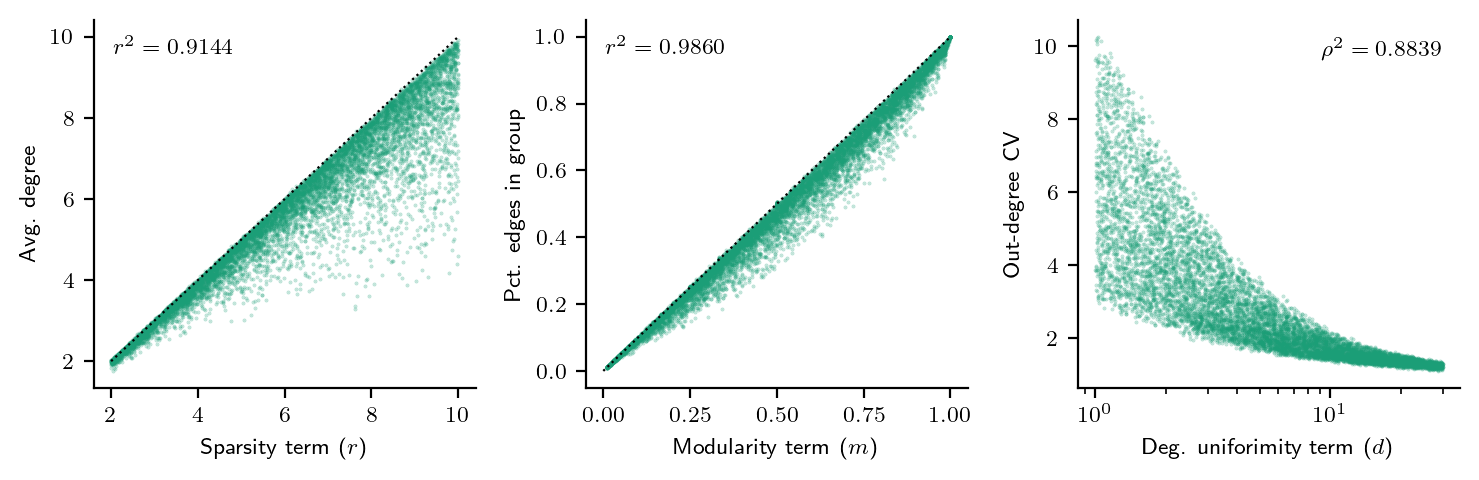

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5), dpi=200)

ax = axs[0]
grns.plot.scatter(
    x = 'r',
    y = 'Avg. degree',
    s = 0.7,
    alpha = 0.3,
    marker = '.',
    ax = ax
)
ax.set_xlabel('Sparsity term ({})'.format(r'$r$'));
ax.plot([2,10], [2,10], 'k:', linewidth=0.8);
ax.text(
    0.05, 
    0.95, 
    '$r^2={:.4f}$'.format(grns[['r','Avg. degree']].corr().iloc[0,1]**2), 
    transform=ax.transAxes, 
    ha='left', 
    va='top',
    fontsize=8
);


ax = axs[1]
grns.plot.scatter(
    x = 'm',
    y = 'Pct. edges in group',
    s = 0.7,
    alpha = 0.3,
    marker = '.',
    ax = ax
)
ax.set_xlabel('Modularity term ({})'.format(r'$m$'));
ax.plot([0,1], [0,1], 'k:', linewidth=0.8);
ax.text(
    0.05, 
    0.95, 
    '$r^2={:.4f}$'.format(grns[['m','Pct. edges in group']].corr().iloc[0,1]**2), 
    transform=ax.transAxes, 
    ha='left', 
    va='top',
    fontsize=8
);


ax = axs[2]
grns.plot.scatter(
    x = 'd',
    y = 'Out-degree CV',
    s = 0.7,
    alpha = 0.3,
    marker = '.',
    ax = ax
)
ax.set_xlabel('Deg. uniforimity term ({})'.format(r'$d$'));
ax.text(
    0.95, 
    0.95, 
    '$\\rho^2={:.4f}$'.format(grns[['d','Out-degree CV']].corr(method='spearman').iloc[0,1]**2), 
    transform=ax.transAxes, 
    ha='right', 
    va='top',
    fontsize=8
);
ax.semilogx();


fig.tight_layout();
sns.despine();
plt.savefig('png/supplement/Fig_S4A.png');

## Heritability distribution

In [4]:
print(sm.ols('y ~ 1 + log_d', data = grns).fit().summary())
model0 = sm.ols('y ~ 1 + I(1/(1 + (r*(gamma**2)))) + p_up', data = grns).fit()
model1 = sm.ols('y ~ 1 + I(1/(1 + (r*(gamma**2)))) + p_up + I(triangles * (p_up - 0.5)) + I(diamonds * ((p_up - 0.5)**2))', data = grns).fit()
print(model0.summary())
print(model1.summary())
grns['resid0'] = model0.resid
grns['resid1'] = model1.resid
print(sm.ols('resid1 ~ 1 + r + gamma + p_up + (log_d) + I(k*((2*p_up)-1)) + I(m*((2*p_up)-1))', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     230.4
Date:                Sat, 02 Aug 2025   Prob (F-statistic):           1.82e-51
Time:                        13:56:16   Log-Likelihood:                -453.49
No. Observations:               10000   AIC:                             911.0
Df Residuals:                    9998   BIC:                             925.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5061      0.005     99.199      0.0

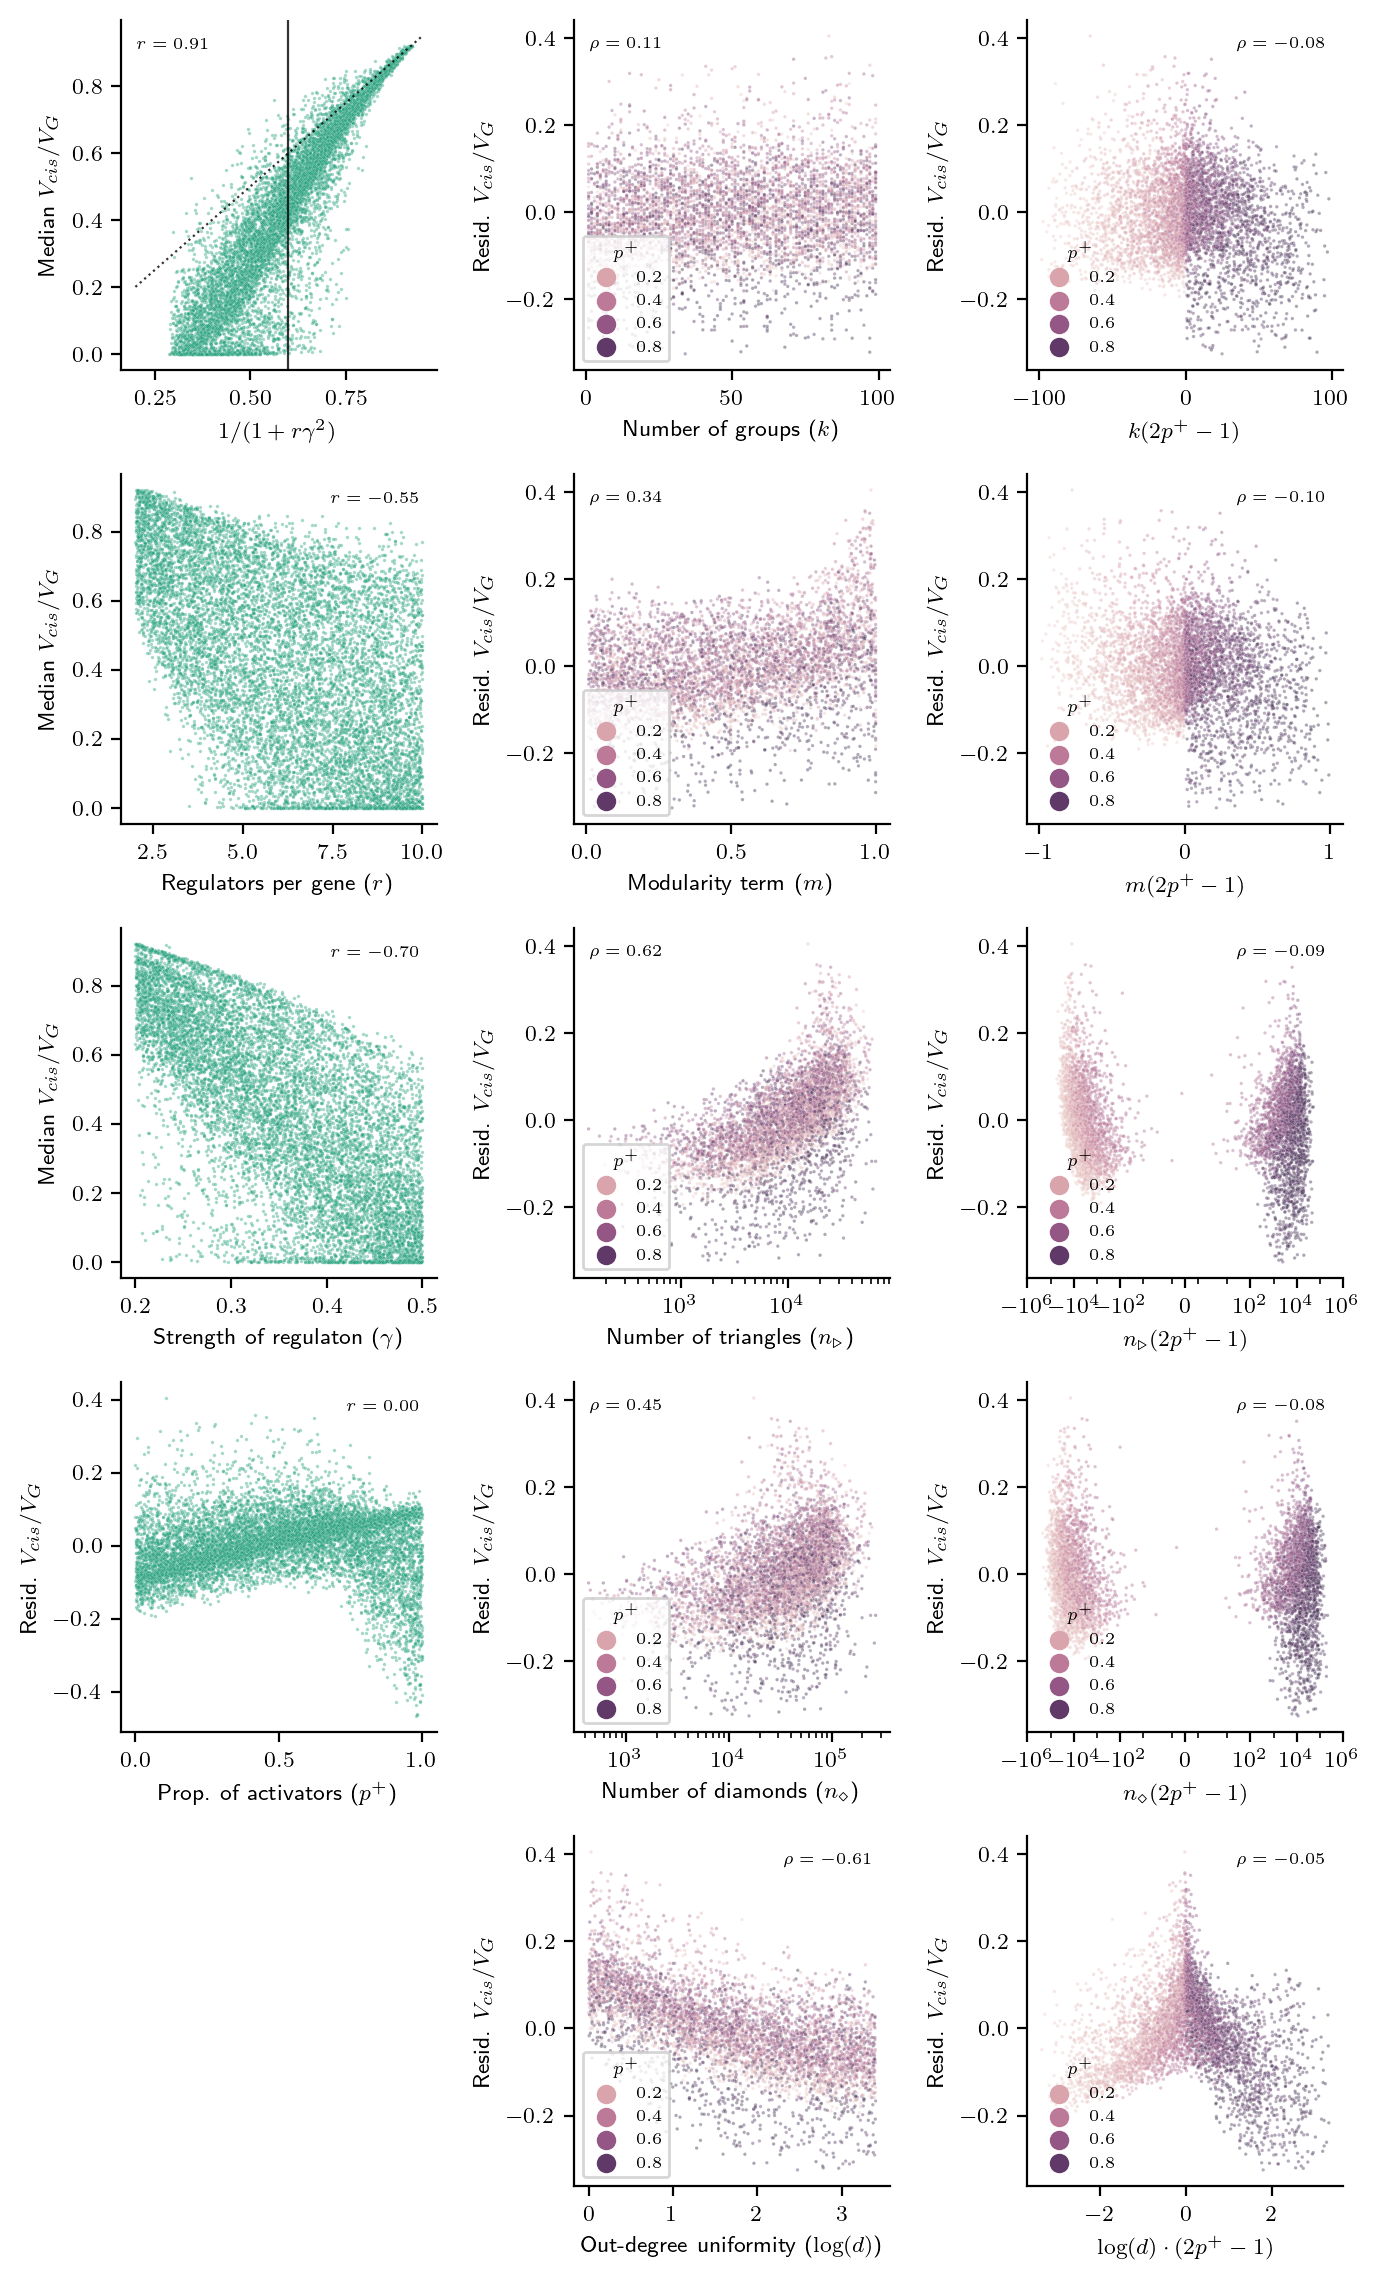

In [5]:
fig, axs = plt.subplots(5, 3, figsize=(7, 11.5), dpi=200);

for ix,(x, xl) in enumerate(
    {
        'I(1 / (1 + (r * (gamma ** 2))))': r'$1/(1+r\gamma^2)$',
        'r': 'Regulators per gene ({})'.format(r'$r$'),
        'gamma': 'Strength of regulaton ({})'.format(r'$\gamma$'),
        #'log_d': 'Out-degree uniformity ({})'.format(r'$\log(d)$'),
        'p_up': 'Prop. of activators ({})'.format(r'$p^+$'),
    }.items()
):
    ax = axs[ix,0]
    if x in ['p_up']:
        y = 'resid0'
        yl = 'Resid. $V_{cis}/V_{G}$'
    else:
        y = 'Median $V_{cis}/V_{G}$'
        yl = y
    sns.scatterplot(
        data = grns,
        y = y,
        x = x,
        s = 1.5,
        alpha = 0.4,
        ax = ax
    );
    ax.set_xlabel(xl);
    ax.set_ylabel(yl);
    if ix == 0:
        ax.plot([0.2, 0.95], [0.2, 0.95], 'k:', linewidth = 0.8, alpha=0.8);
        ax.axvline(x = 0.6, color='k', linestyle='-', linewidth = 0.8, alpha=0.8);
        ha, xx = 'left', 0.05
    else:
        ha, xx = 'right', 0.95
    ax.text(
        xx,
        0.95,
        r'$r={:.2f}$'.format(ss.pearsonr(grns[y], grns[x])[0]),
        ha = ha,
        va = 'top',
        fontsize = 6,
        transform = ax.transAxes
    );
axs[4,0].set_visible(0)

for ix,(x, xl) in enumerate(
    {
        'k': 'Number of groups ({})'.format(r'$k$'),
        'm': 'Modularity term ({})'.format(r'$m$'),
        'triangles': 'Number of triangles ({})'.format(r'$n_\triangleright$'),
        'diamonds': 'Number of diamonds ({})'.format(r'$n_\diamond$'),
        'log_d': 'Out-degree uniformity ({})'.format(r'$\log(d)$'),
    }.items()
):
    ax = axs[ix,1]
    df = grns.loc[grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.6,:]
    y,yl = 'resid0', 'Resid. $V_{cis}/V_{G}$'
    sns.scatterplot(
        data = df,
        y = y,
        x = x,
        hue = 'p_up',
        s = 1.5,
        alpha = 0.4,
        ax = ax
    );
    ax.set_xlabel(xl);
    ax.set_ylabel(yl);
    ax.legend(frameon=1, loc='lower left', fontsize=6, title=r'$p^+$', title_fontsize=6);
    if ix < 4:
        ha, xx = 'left', 0.05
    else:
        ha, xx = 'right', 0.95
    ax.text(
        xx,
        0.95,
        r'$\rho={:.2f}$'.format(ss.spearmanr(df[y], df[x])[0]),
        ha = ha,
        va = 'top',
        fontsize = 6,
        transform = ax.transAxes
    );
    if x in ['triangles','diamonds']:
        ax.set_xscale('log');
        
        
for ix,(x, xl) in enumerate(
    {
        'k': r'$k(2p^+ - 1)$',
        'm': r'$m(2p^+ - 1)$',
        'triangles': r'$n_\triangleright(2p^+ - 1)$',
        'diamonds': r'$n_\diamond(2p^+ - 1)$',
        'log_d': r'$\log(d) \cdot (2p^+ - 1)$',
    }.items()
):
    ax = axs[ix,2]
    df = grns.loc[grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.6,:]
    y,yl = 'resid0', 'Resid. $V_{cis}/V_{G}$'
    df['temp'] = df[x] * (2*df['p_up'] - 1)
    sns.scatterplot(
        data = df,
        y = y,
        x = 'temp',
        hue = 'p_up' if x in ['triangles','diamonds'] else 'p_up',
        s = 1.5,
        alpha = 0.4,
        ax = ax
    );
    ax.set_xlabel(xl);
    ax.set_ylabel(yl);
    ax.legend(frameon=0, loc='lower left', fontsize=6, title=r'$p^+$', title_fontsize=6);
    if ix > 4:
        ha, xx = 'left', 0.05
    else:
        ha, xx = 'right', 0.95
    ax.text(
        xx,
        0.95,
        r'$\rho={:.2f}$'.format(ss.spearmanr(df[y], df['temp'])[0]),
        ha = ha,
        va = 'top',
        fontsize = 6,
        transform = ax.transAxes
    );
    if x in ['triangles','diamonds']:
        ax.set_xscale('symlog');
        ax.set_xticks(sorted([s*(10**x) for x in [2, 4, 6] for s in [-1,1]]+[0]));

sns.despine();
fig.tight_layout();
fig.savefig('png/supplement/Fig_S4B.png');

## Motif counts

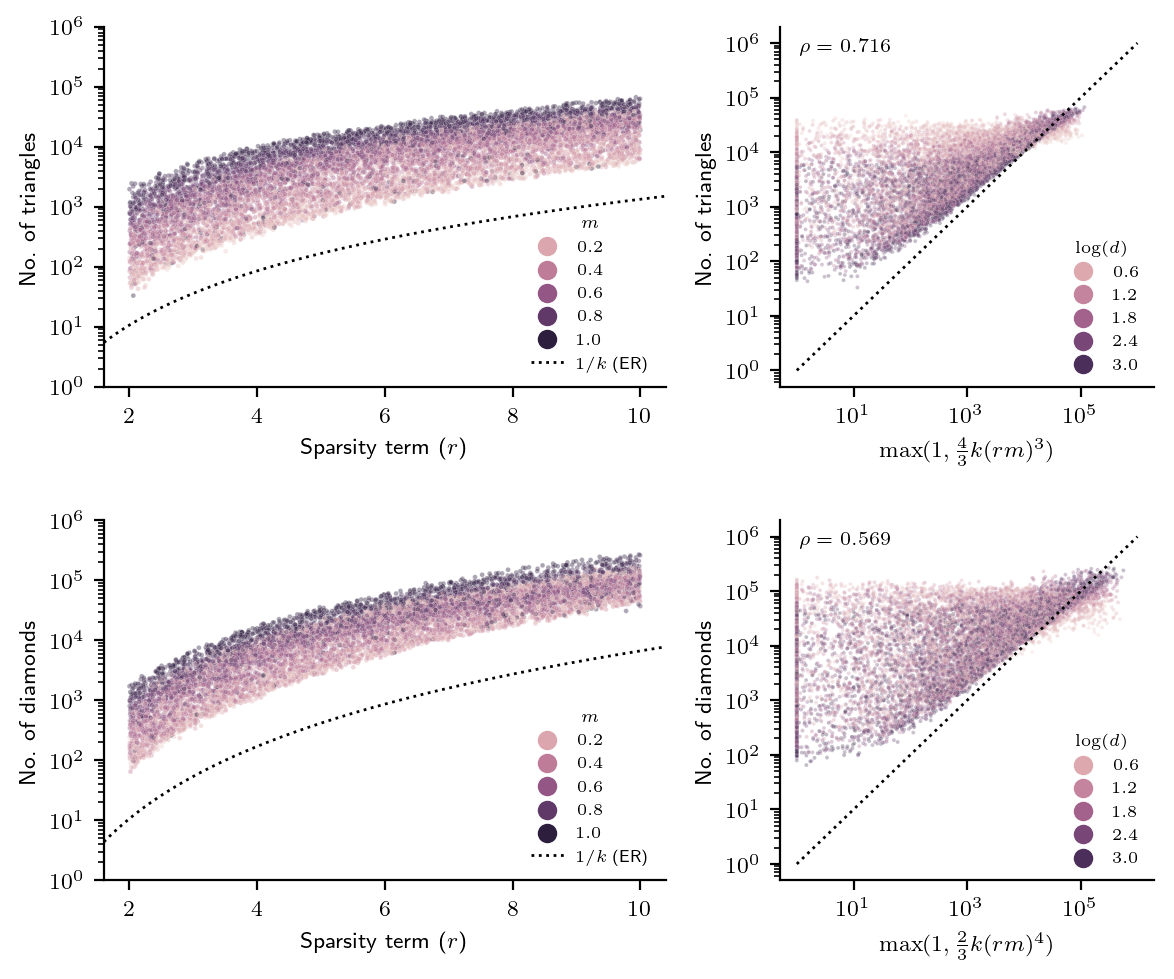

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(6, 5), width_ratios=[0.6, 0.4], dpi=200)

# triangles
ax = axs[0,0]
sns.scatterplot(
    x = 'r', 
    y = 'triangles', 
    hue = 'm', 
    alpha = 0.4, 
    s = 3, 
    data = grns, 
    ax = ax
);
ax.set_xlabel('Sparsity term ({})'.format(r'$r$'));
ax.set_ylabel('No. of triangles');
ax.set_yscale('log');
xl = ax.get_xlim()
xx = np.linspace(*xl, n_sims);
ax.plot(
    xx, 
    scipy.special.comb(grns.n, 3) * (2 * xx / (grns.n - 1)) ** 3, 
    'k:', 
    linewidth=1, 
    label=r'$1/k \text{ (ER)}$'
);
ax.set_xlim(xl);
ax.legend(
    frameon=False, 
    title=r'$m$', 
    fontsize = 6, 
    title_fontsize = 6,
    loc = 'lower right'
);
yl = [1e0, 1e6]
ax.set_ylim(yl);


# triangle math
ax = axs[0,1]
grns[r'$\max(1,\textstyle\frac{4}{3} k (rm)^3)$'] = np.maximum(1, (4/3) * (grns['k']) * (grns['r'] * grns['m']) ** 3)
sns.scatterplot(
    data = grns,
    x = r'$\max(1,\textstyle\frac{4}{3} k (rm)^3)$',
    y = 'triangles',
    hue = 'log_d',
    s = 2.0,
    alpha = 0.3,
    ax = ax
);
ax.legend(
    frameon = False, 
    title = r'$\log(d)$', 
    fontsize = 6, 
    title_fontsize = 6
);
ax.plot([1,1e6],[1,1e6], 'k:', linewidth=1);
ax.set_ylabel('No. of triangles');
ax.text(
    0.05,
    0.97,
    r'$\rho={:.3f}$'.format(scipy.stats.pearsonr((grns['k']) * (grns['r'] * grns['m']) ** 3, grns['triangles'])[0]),
    ha = 'left',
    va = 'top',
    fontsize = 7,
    transform = ax.transAxes
);
ax.loglog();




# diamonds
ax = axs[1,0]
sns.scatterplot(
    x = 'r', 
    y = 'diamonds', 
    hue = 'm', 
    alpha = 0.4, 
    s = 3, 
    data = grns, 
    ax = ax
);
ax.set_xlabel('Sparsity term ({})'.format(r'$r$'));
ax.set_ylabel('No. of diamonds');
ax.set_yscale('log');
xl = ax.get_xlim()
xx = np.linspace(*xl, n_sims);
ax.plot(
    xx, 
    scipy.special.comb(grns.n, 4) * (2 * xx / (grns.n - 1)) ** 4, 
    'k:', 
    linewidth=1, 
    label=r'$1/k \text{ (ER)}$'
);
ax.set_xlim(xl);
ax.legend(
    frameon = False, 
    title = r'$m$', 
    fontsize = 6, 
    title_fontsize = 6
);
yl = [1e0, 1e6]
ax.set_ylim(yl);


# diamond math
ax = axs[1,1]
grns[r'$\max(1,\textstyle\frac{2}{3} k (rm)^4)$'] = np.maximum(1, (2/3) * (grns['k']) * (grns['r'] * grns['m']) ** 4)
sns.scatterplot(
    data = grns,
    x = r'$\max(1,\textstyle\frac{2}{3} k (rm)^4)$',
    y = 'diamonds',
    hue = 'log_d',
    s = 2.0,
    alpha = 0.3,
    ax = ax
);
ax.legend(
    frameon = False, 
    title = r'$\log(d)$', 
    fontsize = 6, 
    title_fontsize = 6
);
ax.plot([1,1e6],[1,1e6], 'k:', linewidth=1);
ax.set_ylabel('No. of diamonds');
ax.text(
    0.05,
    0.97,
    r'$\rho={:.3f}$'.format(scipy.stats.spearmanr((grns['k']) * (grns['r'] * grns['m']) ** 4, grns['diamonds'])[0]),
    ha = 'left',
    va = 'top',
    fontsize = 7,
    transform = ax.transAxes
);

fig.tight_layout();
sns.despine();
ax.loglog();

plt.savefig('png/supplement/Fig_S4C.png');

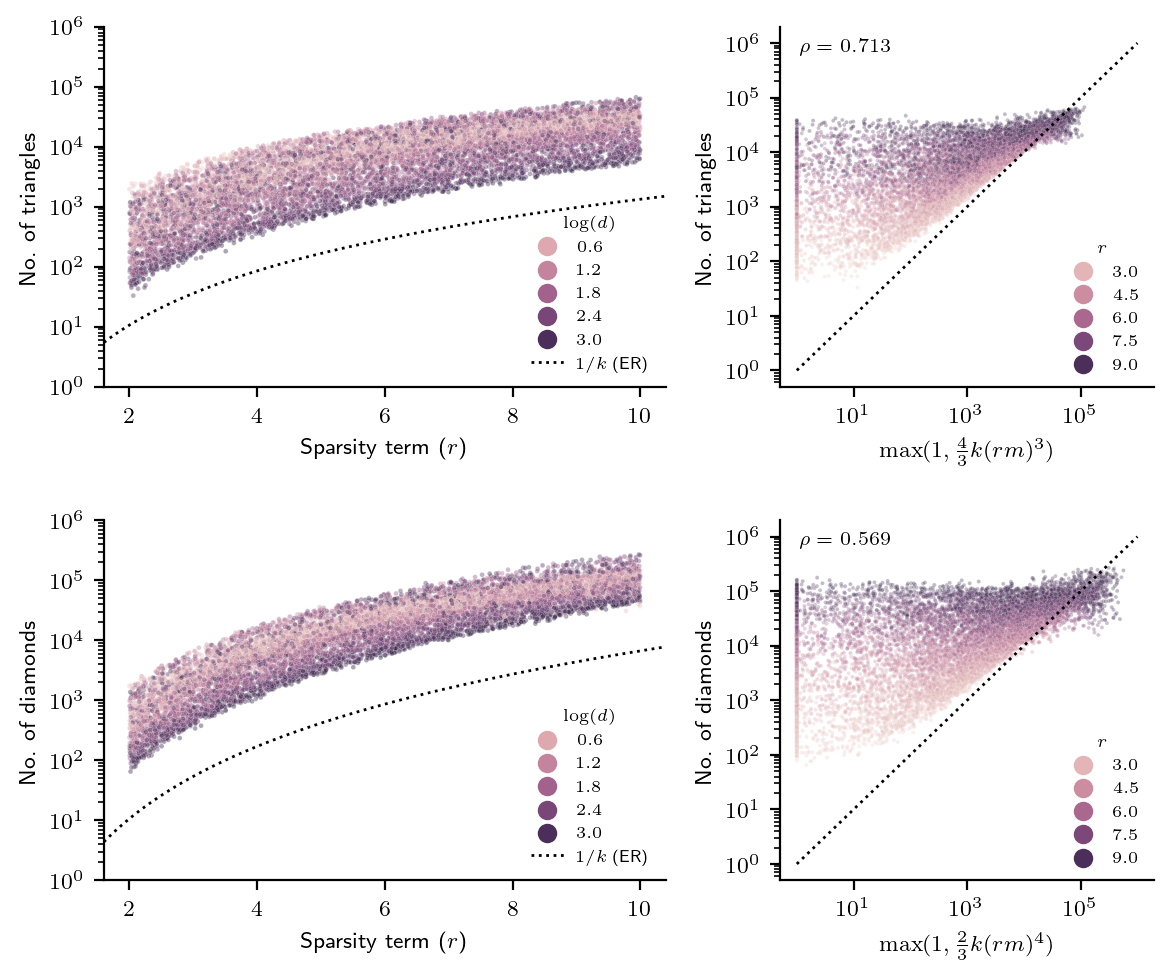

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(6, 5), width_ratios=[0.6, 0.4], dpi=200)

# triangles
ax = axs[0,0]
sns.scatterplot(
    x = 'r', 
    y = 'triangles', 
    hue = 'log_d', 
    alpha = 0.4, 
    s = 3, 
    data = grns, 
    ax = ax
);
ax.set_xlabel('Sparsity term ({})'.format(r'$r$'));
ax.set_ylabel('No. of triangles');
ax.set_yscale('log');
xl = ax.get_xlim()
xx = np.linspace(*xl, n_sims);
ax.plot(
    xx, 
    scipy.special.comb(grns.n, 3) * (2 * xx / (grns.n - 1)) ** 3, 
    'k:', 
    linewidth=1, 
    label=r'$1/k \text{ (ER)}$'
);
ax.set_xlim(xl);
ax.legend(
    frameon=False, 
    title=r'$\log(d)$', 
    fontsize = 6, 
    title_fontsize = 6,
    loc = 'lower right'
);
yl = [1e0, 1e6]
ax.set_ylim(yl);


# triangle math
ax = axs[0,1]
grns[r'$\max(1,\textstyle\frac{4}{3} k (rm)^3)$'] = np.maximum(1, (4/3) * (grns['k']) * (grns['r'] * grns['m']) ** 3)
sns.scatterplot(
    data = grns,
    x = r'$\max(1,\textstyle\frac{4}{3} k (rm)^3)$',
    y = 'triangles',
    hue = 'r',
    s = 2.0,
    alpha = 0.3,
    ax = ax
);
ax.legend(
    frameon = False, 
    title = r'$r$', 
    fontsize = 6, 
    title_fontsize = 6
);
ax.plot([1,1e6],[1,1e6], 'k:', linewidth=1);
ax.set_ylabel('No. of triangles');
ax.text(
    0.05,
    0.97,
    r'$\rho={:.3f}$'.format(scipy.stats.spearmanr((grns['k']) * (grns['r'] * grns['m']) ** 3, grns['triangles'])[0]),
    ha = 'left',
    va = 'top',
    fontsize = 7,
    transform = ax.transAxes
);
ax.loglog();




# diamonds
ax = axs[1,0]
sns.scatterplot(
    x = 'r', 
    y = 'diamonds', 
    hue = 'log_d', 
    alpha = 0.4, 
    s = 3, 
    data = grns, 
    ax = ax
);
ax.set_xlabel('Sparsity term ({})'.format(r'$r$'));
ax.set_ylabel('No. of diamonds');
ax.set_yscale('log');
xl = ax.get_xlim()
xx = np.linspace(*xl, n_sims);
ax.plot(
    xx, 
    scipy.special.comb(grns.n, 4) * (2 * xx / (grns.n - 1)) ** 4, 
    'k:', 
    linewidth=1, 
    label=r'$1/k \text{ (ER)}$'
);
ax.set_xlim(xl);
ax.legend(
    frameon = False, 
    title = r'$\log(d)$', 
    fontsize = 6, 
    title_fontsize = 6
);
yl = [1e0, 1e6]
ax.set_ylim(yl);


# diamond math
ax = axs[1,1]
grns[r'$\max(1,\textstyle\frac{2}{3} k (rm)^4)$'] = np.maximum(1, (2/3) * (grns['k']) * (grns['r'] * grns['m']) ** 4)
sns.scatterplot(
    data = grns,
    x = r'$\max(1,\textstyle\frac{2}{3} k (rm)^4)$',
    y = 'diamonds',
    hue = 'r',
    s = 2.0,
    alpha = 0.3,
    ax = ax
);
ax.legend(
    frameon = False, 
    title = r'$r$', 
    fontsize = 6, 
    title_fontsize = 6
);
ax.plot([1,1e6],[1,1e6], 'k:', linewidth=1);
ax.set_ylabel('No. of diamonds');
ax.text(
    0.05,
    0.97,
    r'$\rho={:.3f}$'.format(scipy.stats.spearmanr((grns['k']) * (grns['r'] * grns['m']) ** 4, grns['diamonds'])[0]),
    ha = 'left',
    va = 'top',
    fontsize = 7,
    transform = ax.transAxes
);

fig.tight_layout();
sns.despine();
ax.loglog();

In [8]:
print(sm.ols('np.log(triangles) ~ 1 + r + k + w + d', data = grns).fit().summary())
print(sm.ols('np.log(diamonds) ~ 1 + r + k + w + d', data = grns).fit().summary());

                            OLS Regression Results                            
Dep. Variable:      np.log(triangles)   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     8265.
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:56:34   Log-Likelihood:                -10650.
No. Observations:               10000   AIC:                         2.131e+04
Df Residuals:                    9995   BIC:                         2.135e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5465      0.025    226.075      0.0

# Figure 4

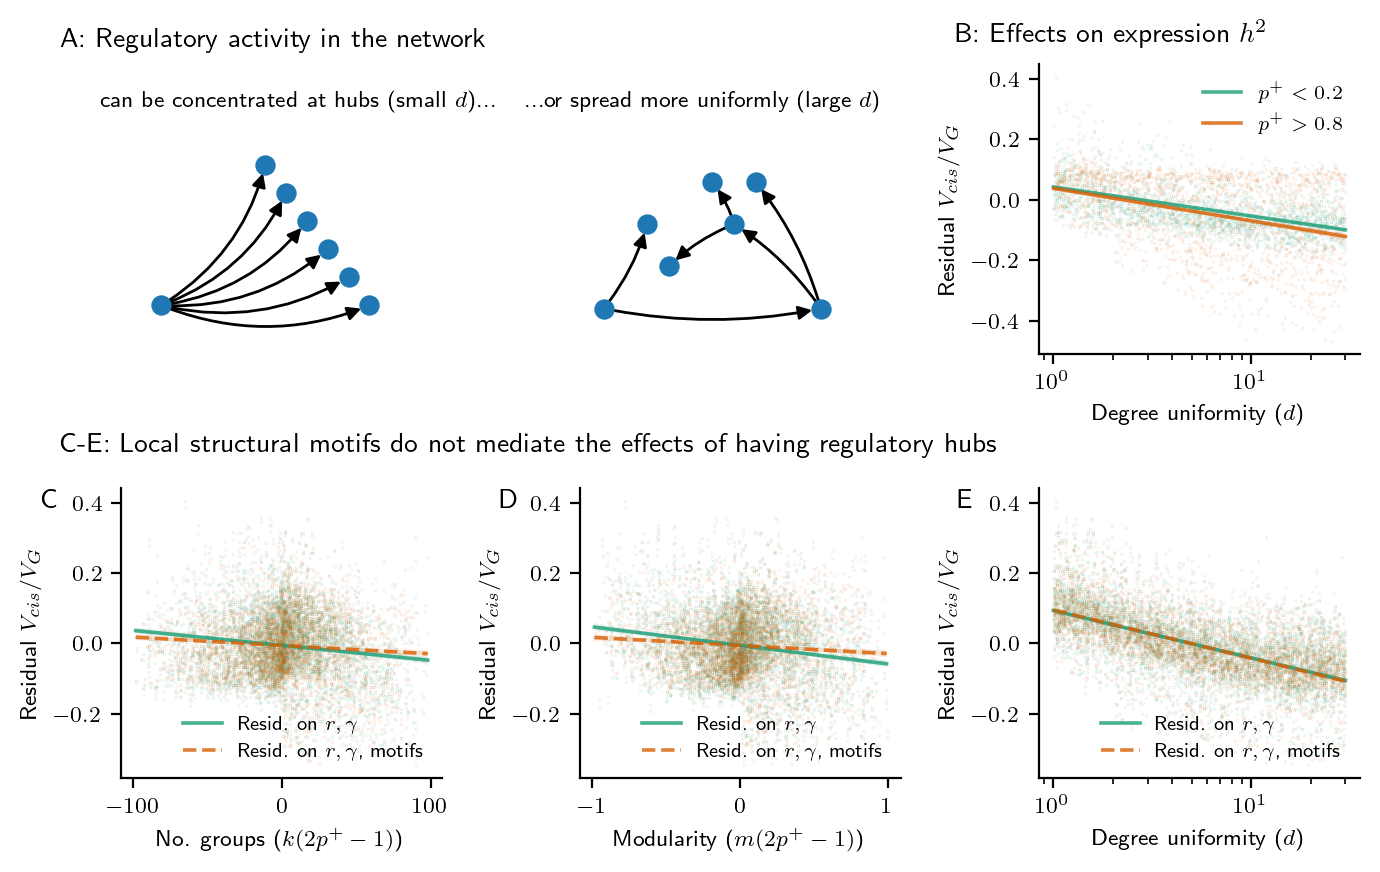

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

ax = axs[0,0]

G = nx.DiGraph([(0,i) for i in range(1,7)])
H = nx.DiGraph([(i,j) for i in range(3) for j in range(i+1, 7, 3)])
nx.draw(G,
        ax = ax,
        pos = nx.planar_layout(G),
        node_size = 40,
        label = None,
        connectionstyle="arc3,rad=0.2")

#print(ax.get_xlim(), ax.get_ylim())
ax.set_xlim(-1.3, 1.1); ax.set_ylim(-0.6, 1.0);


ax = axs[0,1]
nx.draw(H,
        ax = ax,
        pos = nx.planar_layout(H),
        node_size = 40,
        label = None,
        connectionstyle="arc3,rad=0.1")

#print(ax.get_xlim(), ax.get_ylim())
ax.set_xlim(-1.1, 1.7); ax.set_ylim(-0.5, 0.8);

fig.text(0.05, 0.97, 'A: Regulatory activity in the network', ha='left', va='top');
fig.text(0.22, 0.9, 'can be concentrated at hubs (small {})...'.format(r'$d$'), fontsize=8, ha='center', va='top');
fig.text(0.51, 0.9, '...or spread more uniformly (large {})'.format(r'$d$'), fontsize=8, ha='center', va='top');



ax = axs[0,2]
for i, q in enumerate(['p_up < 0.2', 'p_up > 0.8']):
    sns.regplot(
        data = grns.query(q), 
        x = 'd',
        y = 'resid0', #'Median '+r'$V_{cis}/V_{G}$', 
        color = plt.get_cmap('Dark2')(i),
        logx = True,
        scatter = True,
        line_kws = dict(alpha=0.8, linewidth = 1.3, label = r'${}$'.format(q.replace('p_up','p^+'))),
        scatter_kws = dict(s=0.01, alpha=0.3, label=None),
        ax = ax
    )

ax.set_ylabel('Residual ' + r'$V_{cis}/V_{G}$');
ax
ax.legend(frameon=0);
ax.set_xscale('log');
ax.set_xlabel('Degree uniformity ({})'.format(r'$d$'));
ax.set_title(' ');
fig.text(0.69, 0.98, 'B: Effects on expression {}'.format(r'$h^2$'), ha='left', va='top');




for i, (par,label) in enumerate(zip([r'$k(2p^+ - 1)$',r'$m(2p^+ - 1)$','d'], ['No. groups', 'Modularity', 'Degree uniformity'])):
    ax = axs[1, i]
    for j in range(2):
        sns.regplot(
            data = grns.loc[grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.6],
            x = par, 
            y = 'resid' + str(j), 
            ax = ax, 
            logx = (label == 'Degree uniformity'),
            scatter = True,
            line_kws = dict(alpha = 0.8, linewidth=1.3, linestyle='--'[:(1+j)], label='Resid. on ' + r'$r,\gamma$' + ('' if j == 0 else ', motifs')),
            scatter_kws = dict(s = 0.01, alpha=0.3, label='Resid. on ' + r'$r,\gamma$' + ('' if j == 0 else ', motifs')),
        )
    ax.legend(loc='lower right', frameon=False)
    
    ax.set_ylabel('Residual ' + r'$V_{cis}/V_{G}$');
    if (label == 'Degree uniformity'):
        ax.set_xscale('log');
    ax.set_xlabel('{0} ({1})'.format(label, r'$d$' if par == 'd' else par));
    ax.set_title(' ');
    ax.text(-0.25, 1.0, 'CDE'[i], ha='left', va='top', transform=ax.transAxes)
                                

fig.text(0.05, 0.51, 'C-E: Local structural motifs do not mediate the effects of having regulatory hubs', ha='left', va='top');


sns.despine()
fig.tight_layout()

plt.savefig('png/Figure4.png');


In [10]:
df = grns#.query('1./(1 + (r*(gamma**2))) < 0.6')

print(sm.ols('resid0 ~ 1 + I(k * ((2 * p_up) - 1))', data = df).fit().summary())
print(sm.ols('resid1 ~ 1 + I(k * ((2 * p_up) - 1))', data = df).fit().summary())
print(sm.ols('resid0 ~ 1 + I(m * ((2 * p_up) - 1))', data = df).fit().summary())
print(sm.ols('resid1 ~ 1 + I(m * ((2 * p_up) - 1))', data = df).fit().summary())
print(sm.ols('resid0 ~ 1 + log_d', data = df).fit().summary())
print(sm.ols('resid1 ~ 1 + log_d', data = df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 resid0   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.211
Date:                Sat, 02 Aug 2025   Prob (F-statistic):              0.271
Time:                        13:56:41   Log-Likelihood:                 10040.
No. Observations:               10000   AIC:                        -2.008e+04
Df Residuals:                    9998   BIC:                        -2.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2

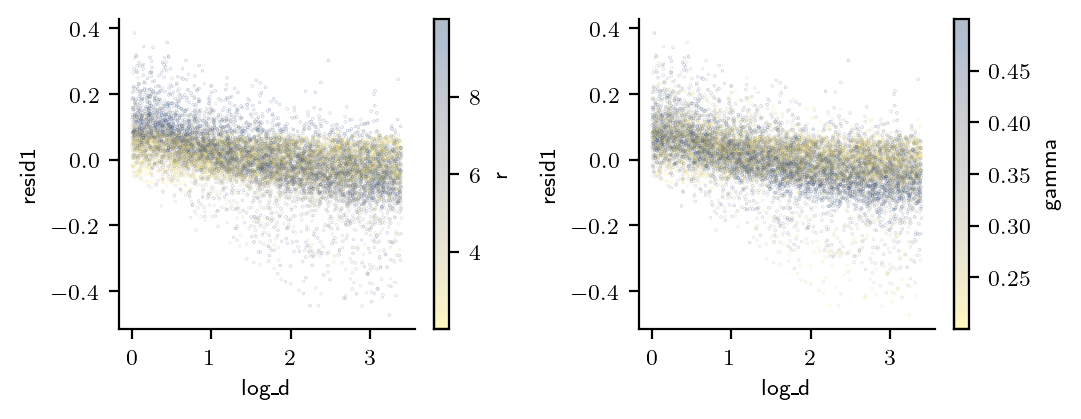

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.2), dpi=200);

ax = axs[0]
grns.plot.scatter(x = 'log_d', y = 'resid1', c = 'r', cmap = 'cividis_r', s = 0.03, alpha = 0.3, ax = ax);

ax = axs[1]
grns.plot.scatter(x = 'log_d', y = 'resid1', c = 'gamma', cmap = 'cividis_r', s = 0.03, alpha = 0.3, ax = ax);

fig.tight_layout();
sns.despine();

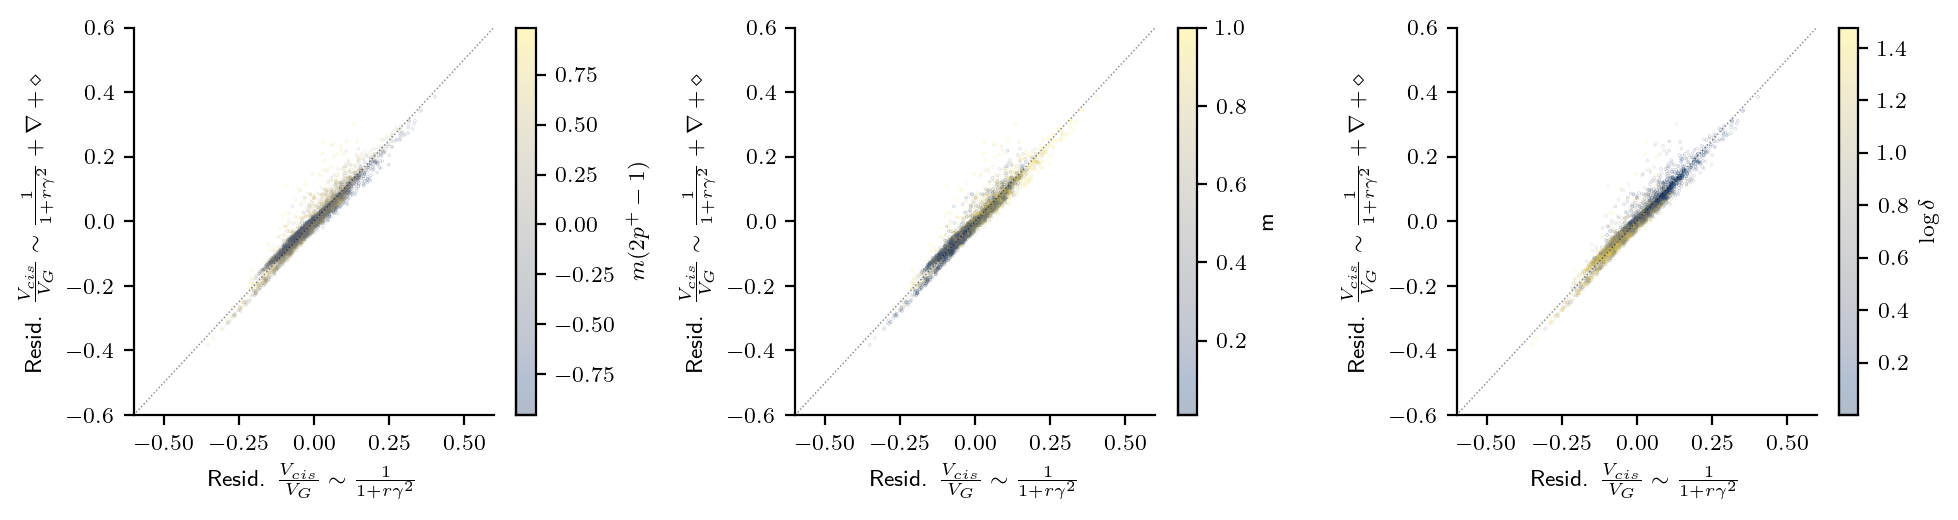

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(9.9, 2.7), dpi=200)

for i,par in enumerate([r'$m(2p^+ - 1)$', 'm', r'$\log \delta$']):
    ax = axs[i]
    grns.query('gamma > 0.35').plot.scatter(x = 'resid0', y = 'resid1', c = par, cmap = 'cividis', s = 0.03, alpha = 0.3, ax = ax);

    ax.set_xlabel('Resid. ' + r'$\frac{V_{cis}}{V_{G}} \sim \frac{1}{1 + r\gamma^2}$', fontsize=8);
    ax.set_ylabel('Resid. ' + r'$\frac{V_{cis}}{V_{G}} \sim \frac{1}{1 + r\gamma^2}+ \nabla + \diamond$', fontsize=8);
    ax.plot([-0.6, 0.6], [-0.6, 0.6], 'k:', alpha=0.5, linewidth=0.5);
    ax.set_xlim(-0.6, 0.6); ax.set_ylim(-0.6, 0.6);

sns.despine();
plt.tight_layout();

# Supplement

## Figure version with all the points

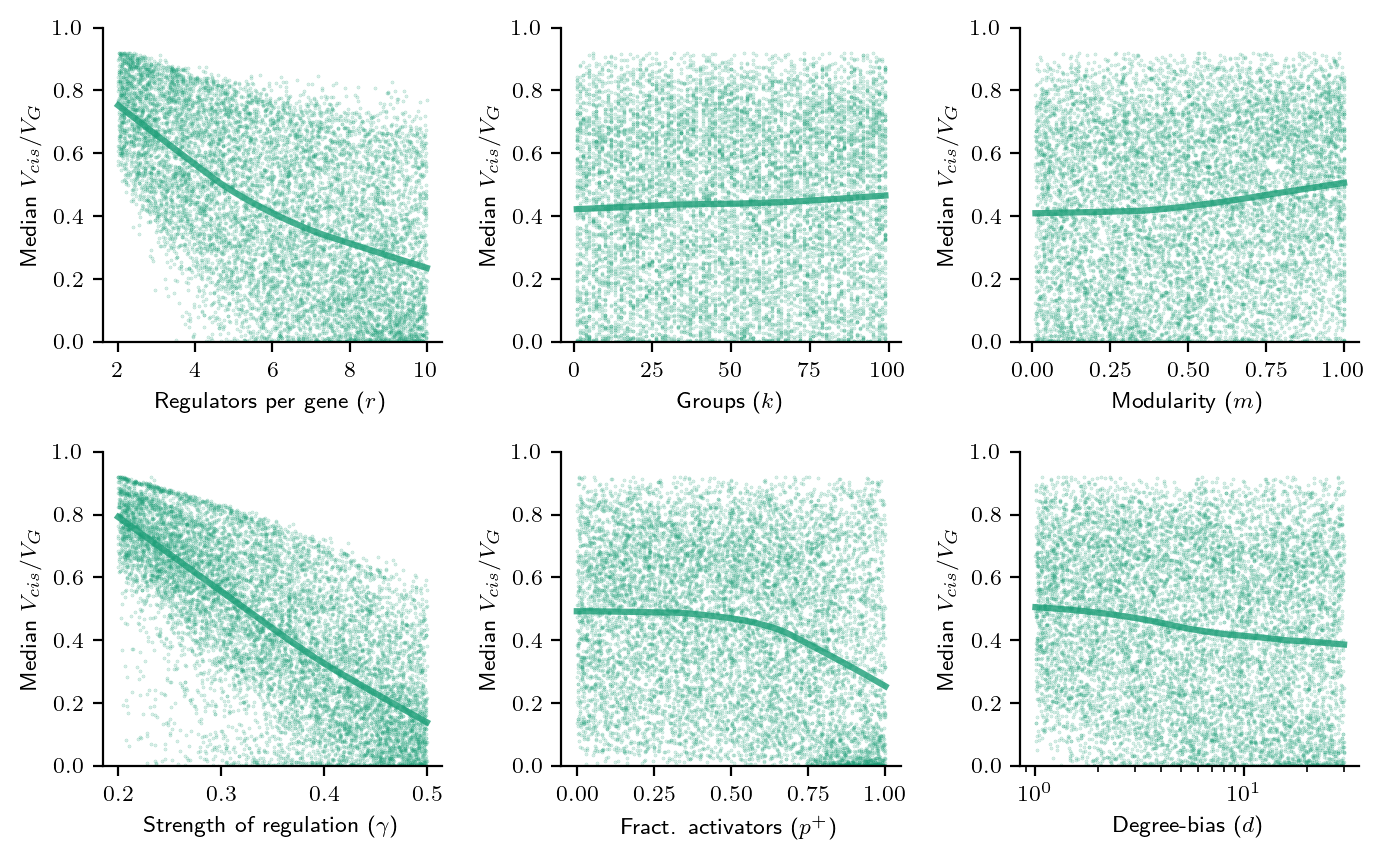

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                np.array(['gamma','p_up','r','k','m','d'])[np.array([2,3,4,0,1,5])],
                                np.array(
                                    ['Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Degree-bias ({})'.format(r'$d$')
                                 ])[np.array([2,3,4,0,1,5])]):
    ax = axs[ix, iy]
    for i, b in enumerate([0]):
        sns.regplot(data = grns.loc[(grns['hier']==b)], 
                    x = par, 
                    y = 'Median '+r'$V_{cis}/V_{G}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=0.1, alpha=0.3, label=None),
                    ax = ax
                   )
    ax.set_ylim(0, 1);
    ax.set_xlabel(label);
    if par in ['d','w']:
        ax.set_xscale('log');
    if ix == 0 and iy == 9:
        ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 2.286e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:56:53   Log-Likelihood:                 9741.1
No. Observations:               10000   AIC:                        -1.947e+04
Df Residuals:                    9996   BIC:                        -1.945e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

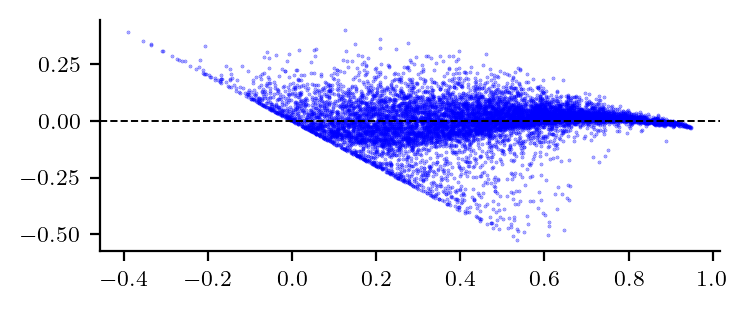

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:56:53   Log-Likelihood:                 12195.
No. Observations:               10000   AIC:                        -2.438e+04
Df Residuals:                    9993   BIC:                        -2.433e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0459      0.004     10.487      0.0

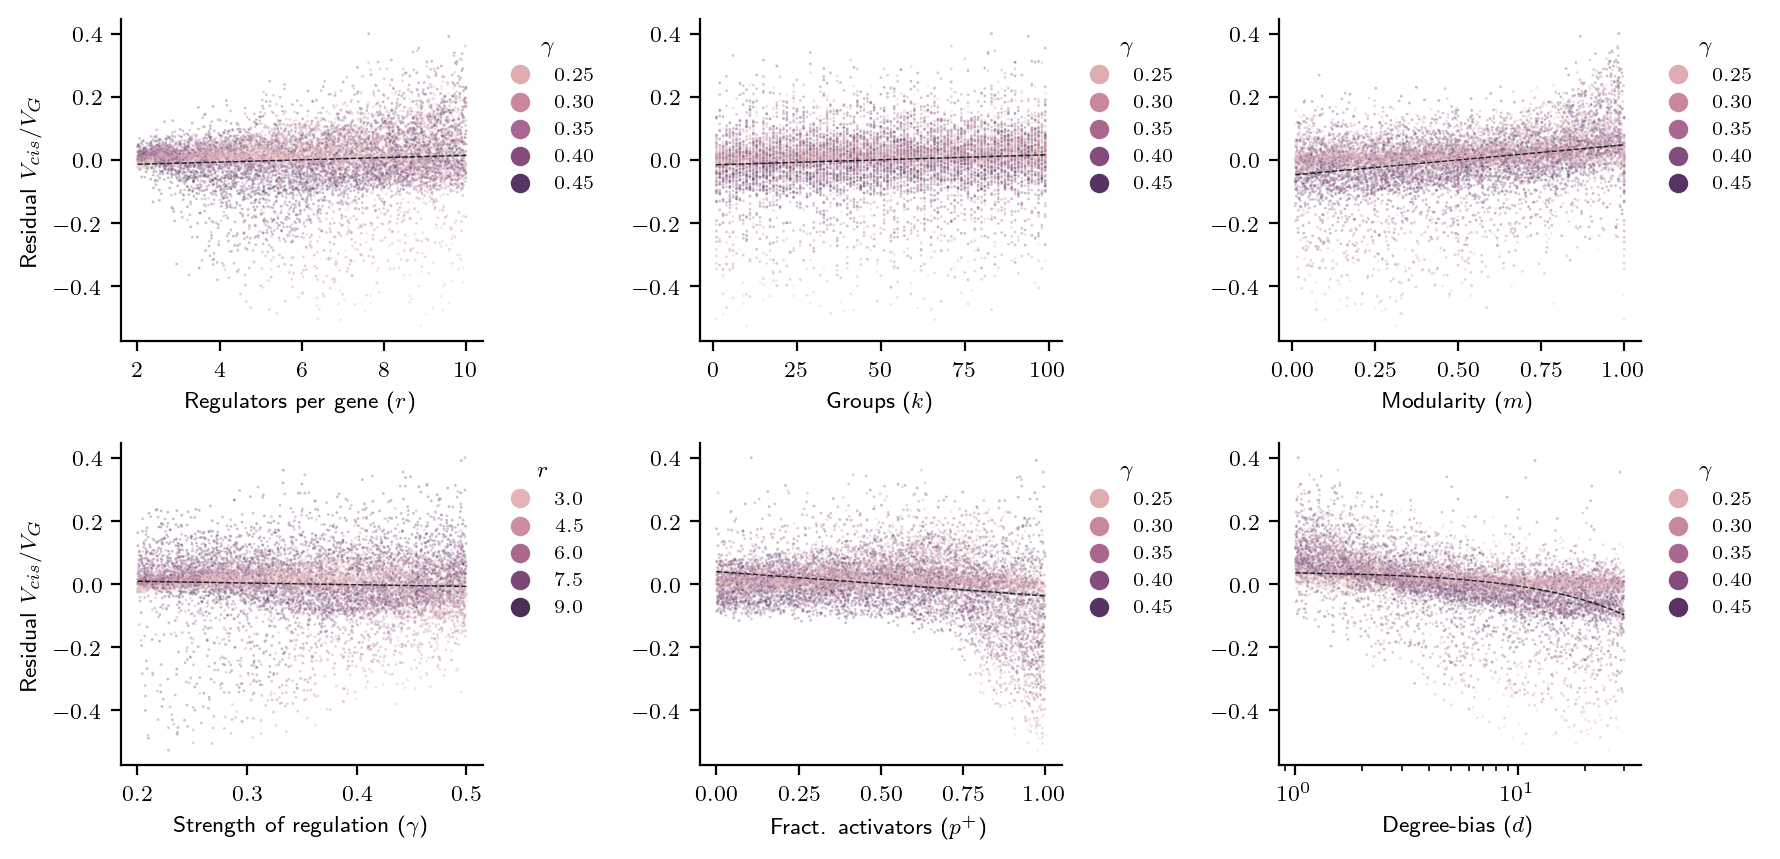

In [14]:
model = sm.ols('y ~ 1 + I(1/(1 + (r*(gamma**2)))) + I(triangles * (p_up - 0.5)) + I(diamonds * ((p_up - 0.5)**2))',# +
               #' + p_up + I(p_up**2) + I(m*(p_up - 0.5))', 
               data = grns).fit()
print(model.summary())

grns['resid'] = model.resid # grns.y - 1/(1 + grns.r*(grns.gamma**2))

plt.figure(figsize=(4, 1.5), dpi=200)
plt.plot(model.fittedvalues, model.resid, 'b.', alpha=0.5, ms=0.7);
plt.axhline(0, color='k', linewidth=0.7, linestyle='dashed');
sns.despine()
plt.show()

print(sm.ols('resid ~ 1 + r + gamma + p_up + m + k + log_d', data = grns).fit().summary())

fig, axs = plt.subplots(2, 3, figsize=(9, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['r','k','m','gamma','p_up','d'],
                                ['Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Degree-bias ({})'.format(r'$d$')
]):
    ax = axs[ix, iy]
    if not par: 
        ax.axis('off');
        continue
    for i, b in enumerate([0]):
        sns.scatterplot(data = grns, 
                        x = par, 
                        y = 'resid', 
                        ax = ax, 
                        hue = 'r' if par == 'gamma' else 'gamma', 
                        s=1, 
                        alpha = 0.3
                       )
        sns.regplot(data = grns, 
                    x = par, 
                    y = 'resid', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = 0,
                    scatter = False,
                    line_kws = dict(alpha=0.8, linewidth=0.5, linestyle='dashed', color='k', label=None),
                    scatter_kws = dict(s=0.1, alpha=0.3, label=None),
                    ax = ax
                   )
    ax.set_xlabel(label);
    ax.set_ylabel('Residual ' + r'$V_{cis}/V_{G}$' if iy == 0 else '')
    if par == 'd':
        ax.set_xscale('log');
    if True:
        ax.legend(fontsize=7, title_fontsize=8, frameon=False, loc='upper left', title=r'$r$' if par == 'gamma' else r'$\gamma$', bbox_to_anchor=(1,1));

# overall figure stuff
sns.despine();
fig.tight_layout();

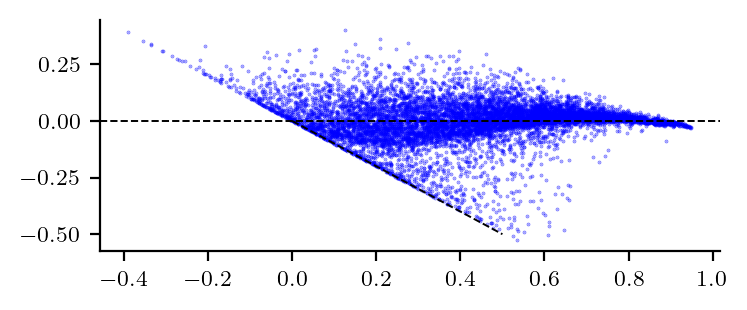

In [15]:
plt.figure(figsize=(4, 1.5), dpi=200)
plt.plot(model.fittedvalues, model.resid, 'b.', alpha=0.5, ms=0.7);
plt.axhline(0, color='k', linewidth=0.7, linestyle='dashed');
plt.plot([0, 0.5], [0, -0.5], 'k--', linewidth=0.7);
sns.despine()
plt.show()

In [16]:
print(sm.ols('y ~ 1 + I(1/(1 + r*(gamma**2))) + I(r * (p_up - 0.5) * m)', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 3.639e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:05   Log-Likelihood:                 10002.
No. Observations:               10000   AIC:                        -2.000e+04
Df Residuals:                    9997   BIC:                        -1.998e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

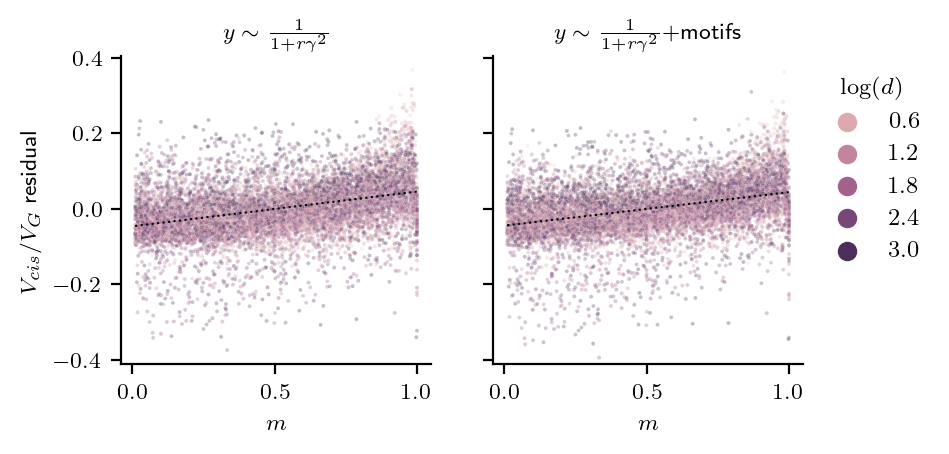

In [17]:
grns['resid'] = sm.ols('y ~ 1 + I(1/(1 + r*(gamma**2))) + p_up + I(p_up**2) + I(-np.log10(d))', data = grns).fit().resid
#print(sm.ols('resid ~ 1 + p_up + I(p_up**2) + I(k * (p_up - 0.5)) + I(m * (p_up - 0.5)) + I(triangles * (p_up - 0.5)) + I(diamonds * p_up * (1 - p_up))', data = grns).fit().summary())

fig, ax = plt.subplots(1, 2, figsize=(4.4, 2), dpi=200)
sns.scatterplot(data = grns, x = 'm', y = 'resid', ax = ax[0], hue = 'log_d', s=2, alpha = 0.3, legend = None)
sns.regplot(data = grns, x = 'm', y = 'resid', ax = ax[0], scatter=False, line_kws=dict(color = 'k', linewidth = 0.75, linestyle = 'dotted'))
ax[0].set_xlabel(r'$m$');
ax[0].set_ylabel(r'$V_{cis}/V_{G}$' + ' residual');
ax[0].set_title(r'$y \sim \frac{1}{1 + r \gamma^2}$');

grns['resid'] = sm.ols('y ~ 1 + I(1/(1 + r*(gamma**2))) + p_up + I(p_up**2) + I(triangles * (p_up - 0.5)) + I(diamonds * ((p_up - 0.5)**2)) + I(-np.log10(d))', data = grns).fit().resid
sns.scatterplot(data = grns, x = 'm', y = 'resid', ax = ax[1], hue = 'log_d', s=2, alpha = 0.3)
sns.regplot(data = grns, x = 'm', y = 'resid', ax = ax[1], scatter=False, line_kws=dict(color = 'k', linewidth = 0.75, linestyle = 'dotted'))
ax[1].legend(fontsize='small', title=r'$\log(d)$', title_fontsize='small', frameon=False, bbox_to_anchor=(1,1));
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_ylabel(None); ax[1].set_yticklabels(['' for _ in ax[1].get_yticklabels()]);
ax[1].set_xlabel(r'$m$');
ax[1].set_title(r'$y \sim \frac{1}{1 + r \gamma^2} + $' + 'motifs');

#plt.tight_layout()
sns.despine()

In [18]:
print(sm.ols('y ~ 1 + gamma + p_up + I(p_up**2) + I(-r) + k + m + triangles + diamonds + I(-np.log(d))', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.264e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:08   Log-Likelihood:                 12017.
No. Observations:               10000   AIC:                        -2.401e+04
Df Residuals:                    9990   BIC:                        -2.394e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6441      0.005    322.629

In [19]:
print(sm.ols('y ~ 1 + gamma + p_up + I(-r) + k + m + I(-np.log(d))', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 1.372e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:08   Log-Likelihood:                 10550.
No. Observations:               10000   AIC:                        -2.109e+04
Df Residuals:                    9993   BIC:                        -2.104e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6533      0.005    320.706

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 1.372e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:08   Log-Likelihood:                 10550.
No. Observations:               10000   AIC:                        -2.109e+04
Df Residuals:                    9993   BIC:                        -2.104e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6533      0.005    320.706      0.0

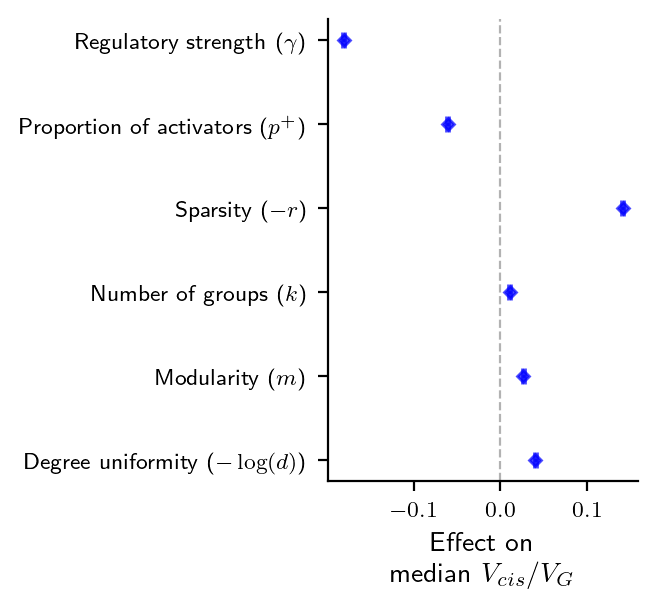

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3), dpi=200);

model = sm.ols('y ~ 1 + gamma + p_up + I(-r) + k + m + I(-log_d)', data = grns).fit()
print(model.summary())

odds = model.conf_int().rename(columns={0:'2.5%', 1:'97.5%'})
odds['Coefficient'] = model.params
odds = odds.drop('Intercept').rename(index={'I(-r)':'r', 'I(-log_d)': 'log_d'})

props = ['gamma', 'p_up', 'r', 'k', 'm', 'log_d'][::-1]
sd = grns[props].std()
ci = (odds['97.5%'] - odds['Coefficient']).loc[props]

names = ['Regulatory strength ({})'.format(r'$\gamma$'), 
         'Proportion of activators ({})'.format(r'$p^+$'), 
         'Sparsity ({})'.format(r'$-r$'), 
         'Number of groups ({})'.format(r'$k$'), 
         'Modularity ({})'.format(r'$m$'), 
         'Degree uniformity ({})'.format(r'$-\log(d)$')][::-1]

yloc = np.array([props.index(w) for w in props])
c = 'blue'
ax.errorbar(x=odds['Coefficient'].loc[props].values * sd, 
            y=yloc, 
            xerr=ci * sd,
            color=c, capsize=3, linestyle='None', linewidth=1, alpha=0.7,
            marker="D", markersize=3, mfc=c, mec=c,
)

ax.axvline(x=0, linewidth=0.8, alpha=0.3, linestyle='--', color='black')
ax.set_yticks(np.arange(len(names)) + 0.00, names);
ax.set_xlabel('Effect on\nmedian '+r'$V_{cis}/V_{G}$', fontsize=10);


sns.despine(); #sns.despine(left=True, right=False); ax.yaxis.tick_right();


In [21]:
grns['y'] = grns['Median '+r'$V_{cis}/V_{G}$']

print(sm.ols('y ~ 1 + gamma + p_up + m + r + d + k + I(m*(p_up - 0.5))', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:08   Log-Likelihood:                 10244.
No. Observations:               10000   AIC:                        -2.047e+04
Df Residuals:                    9992   BIC:                        -2.041e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.5939    

In [22]:
grns['y'] = grns['Median '+r'$V_{cis}/V_{G}$']

print(sm.ols('y ~ 1 + p_up + r + d + k + m + triangles + diamonds', data = grns.query('~hier')).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     954.5
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:08   Log-Likelihood:                 1992.8
No. Observations:               10000   AIC:                            -3970.
Df Residuals:                    9992   BIC:                            -3912.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9674      0.010     94.443      0.0

In [23]:
grns['y'] = grns['Median '+r'$V_{cis}/V_{G}$']

print(sm.ols('y ~ 1 + p_up + r + d + triangles + diamonds', data = grns.query('~hier')).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     1334.
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:09   Log-Likelihood:                 1988.2
No. Observations:               10000   AIC:                            -3964.
Df Residuals:                    9994   BIC:                            -3921.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9850      0.008    125.060      0.0

In [24]:
grns['y'] = grns['Median '+r'$V_{cis}/V_{G}$']

print(sm.ols('y ~ 1 + p_up + triangles + diamonds', data = grns.query('~hier')).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     830.7
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:09   Log-Likelihood:                 545.59
No. Observations:               10000   AIC:                            -1083.
Df Residuals:                    9996   BIC:                            -1054.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6106      0.005    119.201      0.0

In [25]:
grns['Mean '+r'$V_{cis}/V_{G}$'] = grns[r'$V_{cis}/V_{G}$'].apply(lambda x: np.quantile(x, q=0.2))
grns['y2'] = grns['Mean '+r'$V_{cis}/V_{G}$']

print(sm.ols('y2 ~ 1 + r + gamma + p_up + k + w + d', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 1.246e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:57:10   Log-Likelihood:                 10713.
No. Observations:               10000   AIC:                        -2.141e+04
Df Residuals:                    9993   BIC:                        -2.136e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5238      0.005    325.395      0.0

## QTL effects

model     n         r   k          d     gamma      p_up   hier  \
484   dsfg  5000  3.991069  15  14.063739  0.437504  0.072184  False   
1487  dsfg  5000  4.347832   6  12.893855  0.434763  0.137647  False   

              w         m  ... $k(2p^+ - 1)$ $\log \delta$  $r \log \delta$  \
484   85.033401  0.858634  ...    -12.834476      1.148101         4.582149   
1487  41.719382  0.892978  ...     -4.348231      1.110383         4.827758   

        resid0    resid1 $\max(1,\textstyle\frac{4}{3} k (rm)^3)$  \
484  -0.090259 -0.073905                               804.861433   
1487 -0.112134 -0.098792                               468.199169   

     $\max(1,\textstyle\frac{2}{3} k (rm)^4)$     resid  Mean $V_{cis}/V_{G}$  \
484                               1379.075879  0.024449              0.281940   
1487                               908.896002 -0.028125              0.236047   

            y2  
484   0.281940  
1487  0.236047  

[2 rows x 38 columns]

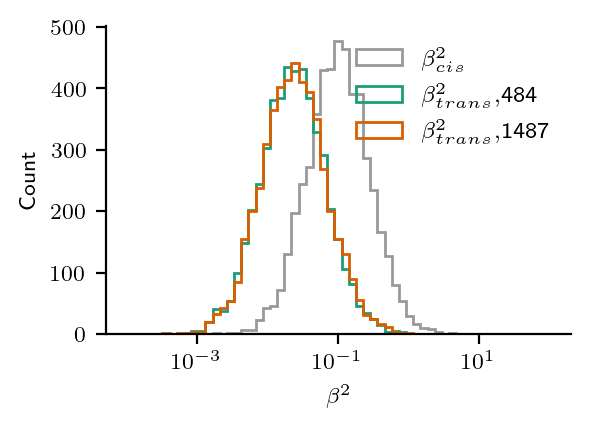

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(3,2), dpi=200)

V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-4, 1e2, 60),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

x = grns.iloc[[484,1487],:]
display(x)

for ix in x.index:
    with open('.'.join((grn_stub, str(ix), 'pkl')), 'rb') as g:
        G = pickle.load(g)  
    
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
             histtype='step', 
             bins=np.geomspace(1e-4, 1e2, 60),
             label=r'$\beta^2_{trans},$'+str(ix)
            );
    
ax.legend(fontsize='small', frameon=False);
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');
sns.despine();

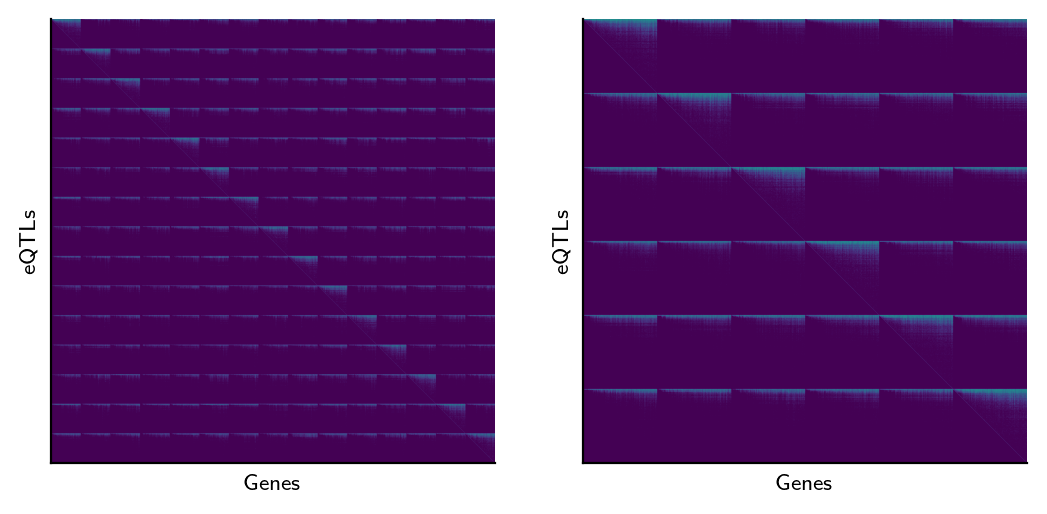

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6.3, 3), dpi=200);

for i,g_ix in enumerate(x.index):
    with open('.'.join((grn_stub, str(g_ix), 'pkl')), 'rb') as g:
        G = pickle.load(g) 
        
    o = np.array([gene for group in range(max(G.I) + 1) for gene,gp in enumerate(G.I) if gp == group])
    V = np.abs(G.L) / np.sqrt(np.abs(G.L.T @ G.L))
    V = V[np.ix_(o,o)]
        
    ax[i].imshow(np.clip(np.nan_to_num(np.log10(V), -3), -3, 3))
    #ax[i].xaxis.set_visible(False);
    #ax[i].yaxis.set_visible(False);
    #ax[i].axis('off');
    ax[i].set_xticks([]);
    ax[i].set_yticks([]);

    ax[i].set_ylabel('eQTLs');    
    ax[i].set_xlabel('Genes');
    
sns.despine();

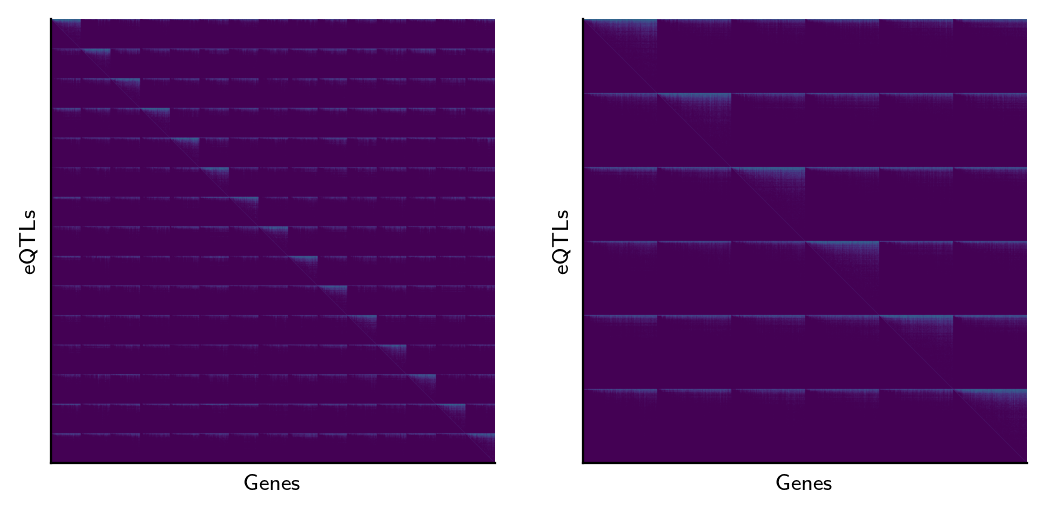

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(6.3, 3), dpi=200);

for i,g_ix in enumerate(x.index):
    with open('.'.join((grn_stub, str(g_ix), 'pkl')), 'rb') as g:
        G = pickle.load(g) 

    o = np.array([gene for group in range(max(G.I) + 1) for gene,gp in enumerate(G.I) if gp == group])
    V = np.abs(G.L) / np.sqrt(np.abs(G.L.T @ G.L))
    V = V[np.ix_(o,o)]
        
    ax[i].imshow(np.clip(np.nan_to_num(np.log10(V), -2), -2, 2), vmin=-2, vmax=2)
    ax[i].set_xticks([]);
    ax[i].set_yticks([]);

    ax[i].set_ylabel('eQTLs');    
    ax[i].set_xlabel('Genes');
    
sns.despine();

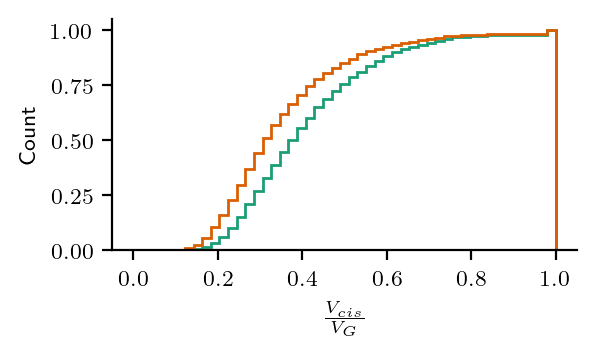

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(3,1.5), dpi=200)

for ix in x.index:
    with open('.'.join((grn_stub, str(ix), 'pkl')), 'rb') as g:
        G = pickle.load(g)
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist(G.cish2, 
            histtype='step',
            cumulative=True,
            density=True,
            bins=np.linspace(0, 1, 50), 
            );
    
ax.set_xlabel(r'$\frac{V_{cis}}{V_{G}}$'); 
ax.set_ylabel('Count');
sns.despine();

## Incoming and outgoing _trans_-effects

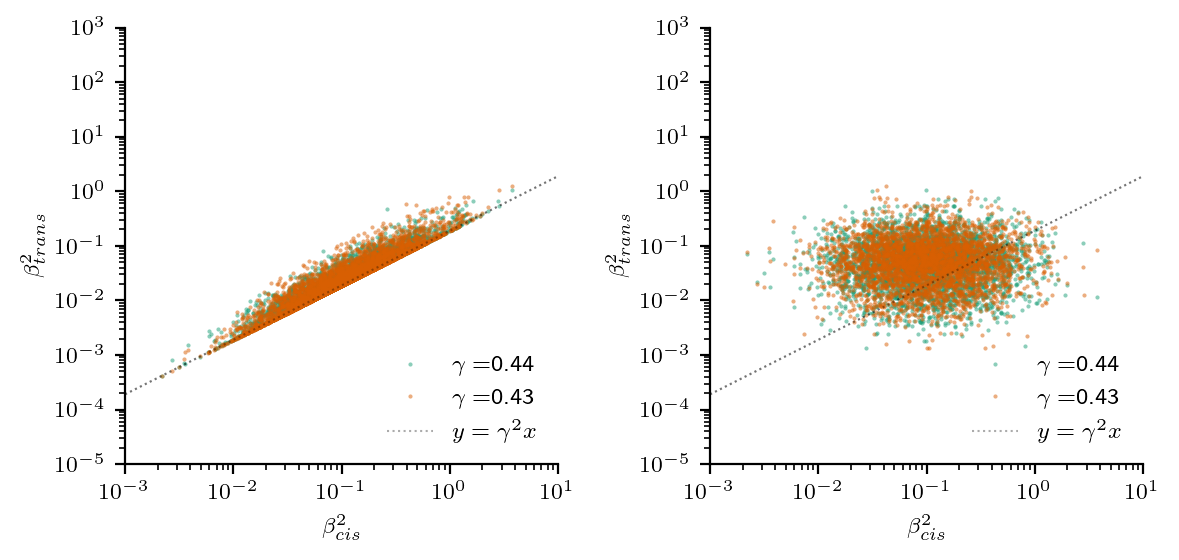

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.9), dpi=200);

V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))

xl = np.array([1e-3,1e1])
yl = np.array([1e-5,1e3])

for i,(_,row) in enumerate(x.iterrows()):
    with open('.'.join((grn_stub, str(row.name), 'pkl')), 'rb') as g:
        G = pickle.load(g)
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    for j in range(2):
        axs[j].plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=j),
                 '.',
                 alpha=0.5,
                 ms=1,
                 label=r'$\gamma=$'+'{:.2f}'.format(row.gamma)
                );

        axs[j].plot(xl, row.gamma**2 * xl, 'k:', alpha=0.33, linewidth=0.75, label=r'$y = \gamma^2 x$' if i==1 else None);

for ax in axs:
    ax.legend(fontsize='small', frameon=False, loc='lower right');
    ax.set_xscale('log');
    ax.set_yscale('log');
    ax.set_xlabel(r'$\beta^2_{cis}$'); 
    ax.set_ylabel(r'$\beta^2_{trans}$'); 
    ax.set_xlim(xl);
    ax.set_ylim(yl);
    
sns.despine();
fig.tight_layout();

## Where is trans-eQTL signal?

In [31]:
var_d1 = grns.query('5.9 < r & r < 6.1 & 48 < k & k < 52 & m > 0.8').sort_values('d')
var_d2 = grns.query('5.85 < r & r < 6.15 & 48 < k & k < 52 & m < 0.2').sort_values('d')
var_d = pd.concat([var_d1, var_d2])
var_d

model     n         r   k          d     gamma      p_up   hier  \
1736  dsfg  5000  6.086616  49   1.020268  0.474446  0.931617  False   
1932  dsfg  5000  5.984577  51   8.021280  0.277468  0.268215  False   
6514  dsfg  5000  5.919387  50  17.062341  0.437180  0.249230  False   
5199  dsfg  5000  6.065669  51   1.195792  0.298895  0.480002  False   
3068  dsfg  5000  6.095148  50   2.097302  0.416725  0.631298  False   
8376  dsfg  5000  6.121870  49  10.033869  0.413519  0.549616  False   

                w         m  ... $k(2p^+ - 1)$ $\log \delta$  $r \log \delta$  \
1736   555.468876  0.920460  ...     42.298493      0.008714         0.053041   
1932  1401.282240  0.965548  ...    -23.642068      0.904244         5.411516   
6514   406.965179  0.892536  ...    -25.077022      1.232039         7.292913   
5199     7.239264  0.126474  ...     -2.039747      0.077656         0.471034   
3068     1.844319  0.036274  ...     13.129823      0.321661         1.960571   
8376     1.784118  0.035837  ...      4.862366      1.001468         6.130860   

        resid0    resid1 $\max(1,\textstyle\frac{4}{3} k (rm)^3)$  \
1736  0.086400  0.095229                             11488.865037   
1932  0.066775  0.053193                             13119.896430   
6514  0.016118  0.006441                              9831.405200   
5199  0.078443  0.073574                                30.700546   
3068  0.020491  0.013892                                 1.000000   
8376 -0.057003 -0.067210                                 1.000000   

     $\max(1,\textstyle\frac{2}{3} k (rm)^4)$     resid  Mean $V_{cis}/V_{G}$  \
1736                             32183.102050  0.081357              0.057435   
1932                             37905.966605  0.048714              0.603381   
6514                             25970.952933  0.048961              0.207862   
5199                                11.775929 -0.023141              0.508414   
3068                                 1.000000 -0.047374              0.154985   
8376                                 1.000000 -0.068788              0.140385   

            y2  
1736  0.057435  
1932  0.603381  
6514  0.207862  
5199  0.508414  
3068  0.154985  
8376  0.140385  

[6 rows x 38 columns]

In [32]:
G = {}

for g in var_d.index:
    with open('figdata/graphs/dsfg.graphs.{}.pkl'.format(g), 'rb') as f:
        G[g] = pickle.load(f)
    if 'V_dist' not in dir(G[g]):
        G[g].decompose_variance()
        with open('figdata/graphs/dsfg.graphs.{}.pkl'.format(g), 'wb') as f:
            pickle.dump(G[g], f)
    G[g].M = scipy.sparse.csc_array(G[g].A != 0)
    #G[g].B = (G[g].L ** 2 - np.eye(G[g].n)) / np.diag(G[g].L.T.dot(G[g].L))

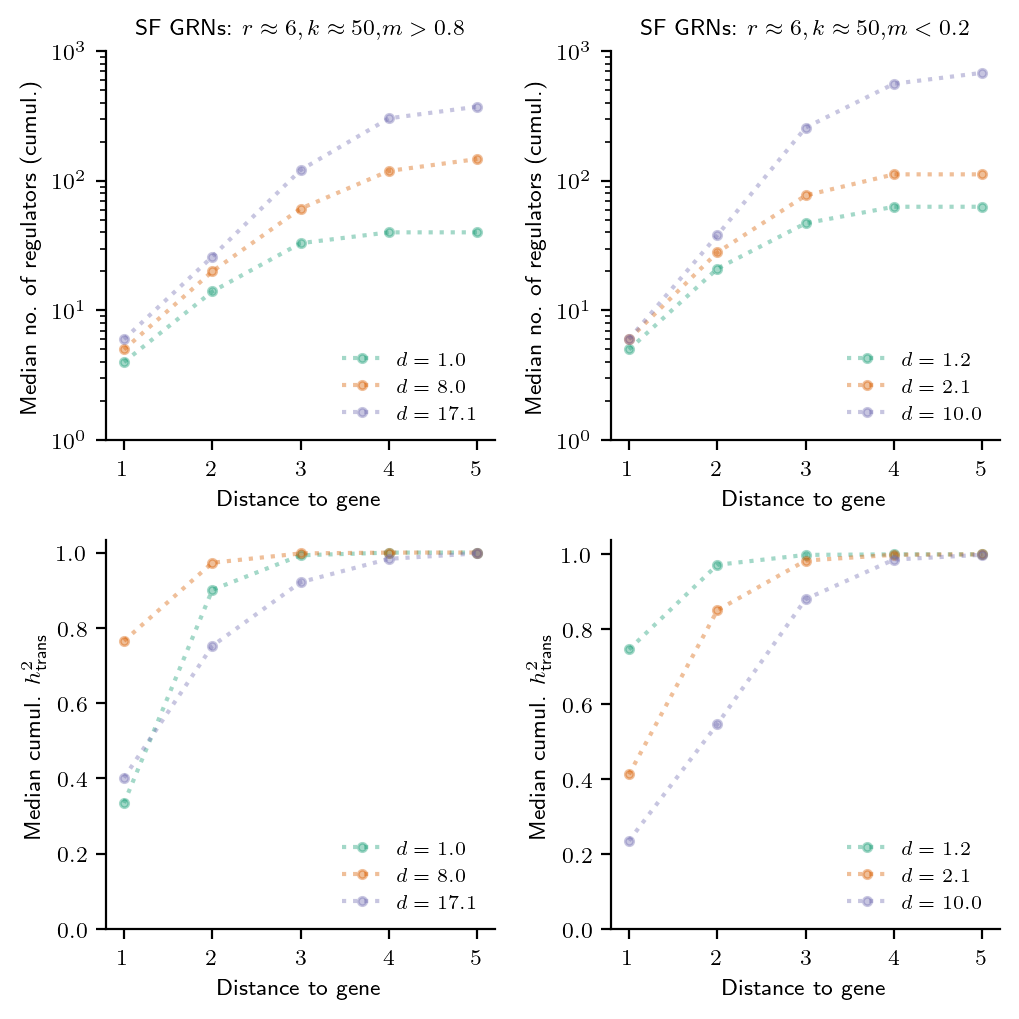

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(5.2, 5.2), dpi=200);

max_d = 5
for i,row in var_d.iterrows():
    ax = axs[0, int(row['m'] < 0.2)]
    s = r'$d = {:.1f}$'.format(row['d'])
    m = [r'$m > 0.8$', r'$m < 0.2$'][int(row['m'] < 0.2)]
    M = G[row.name].M
    
    # compute neighbors at dist. d
    y = []
    for d in range(max_d):
        y.append(np.median(M[:,2000:3000].sum(axis=0)))
        M = M.dot(M)
    
    # plot cumulative
    ax.plot(
        range(1, max_d + 1),
        np.cumsum(y),
        marker = '.',
        linestyle = 'dotted',
        alpha = 0.4,
        label = s
    )

    ax.set_xlabel('Distance to gene');
    ax.set_ylabel('Median no. of regulators (cumul.)');
    ax.set_yscale('log');
    ax.set_ylim(1, 1000);
    ax.legend(
        loc = 'lower right',
        frameon = 0
    );
    ax.set_title(
        'SF GRNs: ' + r'$r \approx 6, k \approx 50,$' + m,
    );
    
    ax = axs[1, int(row['m'] < 0.2)]
    ax.plot(
        range(1,6), 
        np.nanmedian(
            np.cumsum(np.diff(G[row.name].V_dist[2000:3000,:6]), axis=1) / 
            (1 - G[row.name].V_dist[2000:3000,[0]]), axis=0),
        '.:',
        alpha = 0.4,
        label=s
    );
    ax.set_xlabel('Distance to gene');
    ax.set_yticks(np.linspace(0, 1, 6));
    ax.set_ylabel('Median cumul. '+r'$h^2_\text{trans}$');
    ax.legend(frameon=False, loc = 'lower right');

sns.despine();
fig.tight_layout();
fig.savefig('png/supplement/Fig_S4D.png')

In [34]:
var_d[['r','k','m','d','triangles','diamonds']]

r   k         m          d  triangles  diamonds
1736  6.086616  49  0.920460   1.020268      13847     17855
1932  5.984577  51  0.965548   8.021280      20687     57062
6514  5.919387  50  0.892536  17.062341      14019     40713
5199  6.065669  51  0.126474   1.195792      12864     36694
3068  6.095148  50  0.036274   2.097302       9700     37243
8376  6.121870  49  0.035837  10.033869       1954     10709

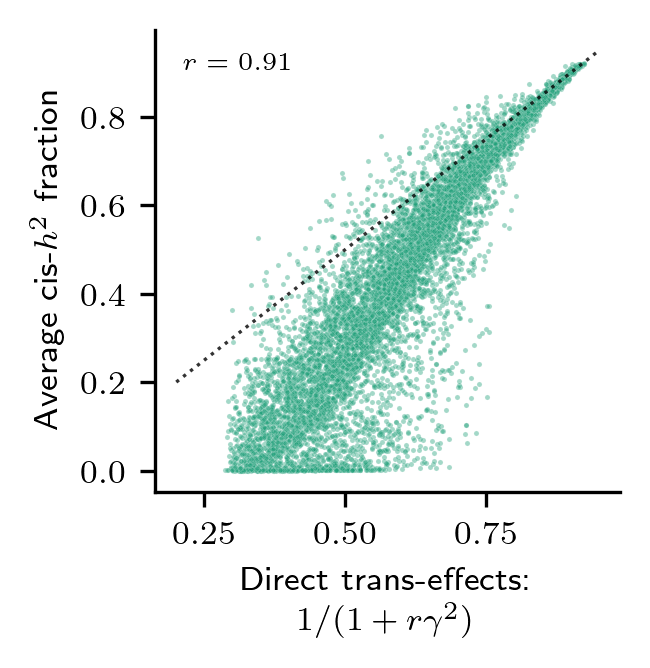

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300);

y = 'Median '+r'$V_{cis}/V_{G}$'
x = 'I(1 / (1 + (r * (gamma ** 2))))'

sns.scatterplot(
    data = grns,
    y = y,
    x = x,
    s = 1.5,
    alpha = 0.4,
    ax = ax
);
ax.set_xlabel('Direct trans-effects:\n{}'.format(r'$1/(1+r\gamma^2)$'));
ax.set_ylabel('Average cis-{} fraction'.format(r'$h^2$'));
ax.plot([0.2, 0.95], [0.2, 0.95], 'k:', linewidth = 0.8, alpha=0.8);
ax.text(
    0.3,
    0.95,
    r'$r={:.2f}$'.format(ss.pearsonr(grns[y], grns[x])[0]),
    ha = ha,
    va = 'top',
    fontsize = 6,
    transform = ax.transAxes
);
sns.despine();

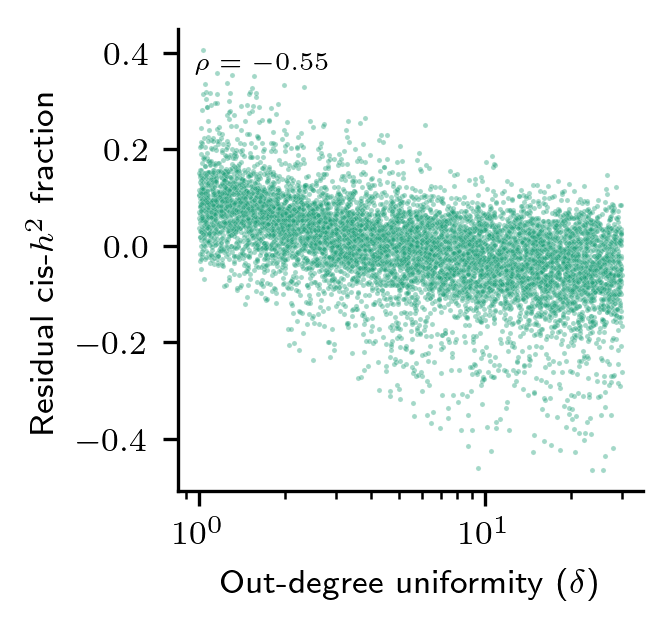

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300);

y = 'resid0'
x = 'd'
ix = grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.75

sns.scatterplot(
    data = grns.loc[ix, :],
    y = y,
    x = x,
    s = 1.5,
    alpha = 0.4,
    ax = ax
);
ax.set_xlabel('Out-degree uniformity ({})'.format(r'$\delta$'));
ax.set_ylabel('Residual cis-{} fraction'.format(r'$h^2$'));
ax.text(
    0.33,
    0.95,
    r'$\rho ={:.2f}$'.format(ss.spearmanr(grns.loc[ix,y], grns.loc[ix,x])[0]),
    ha = ha,
    va = 'top',
    fontsize = 6,
    transform = ax.transAxes
);
ax.semilogx();
sns.despine();

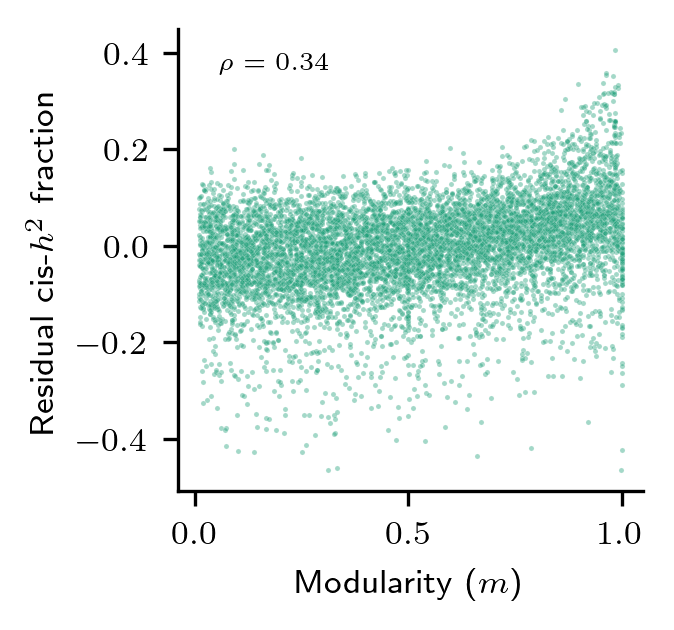

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300);

y = 'resid0'
x = 'm'
ix = grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.75

sns.scatterplot(
    data = grns.loc[ix, :],
    y = y,
    x = x,
    s = 1.5,
    alpha = 0.4,
    ax = ax
);
ax.set_xlabel('Modularity ({})'.format(r'$m$'));
ax.set_ylabel('Residual cis-{} fraction'.format(r'$h^2$'));
ax.text(
    0.33,
    0.95,
    r'$\rho ={:.2f}$'.format(ss.spearmanr(grns.loc[ix,y], grns.loc[ix,x])[0]),
    ha = ha,
    va = 'top',
    fontsize = 6,
    transform = ax.transAxes
);
sns.despine();

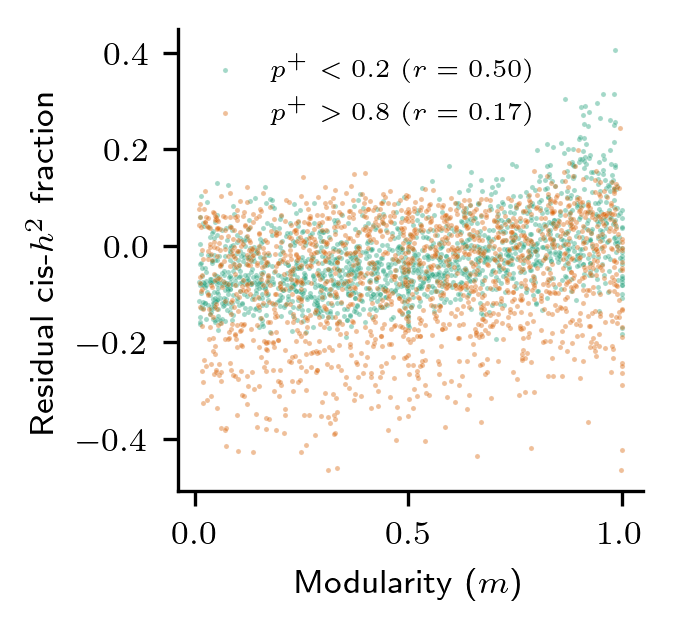

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300);

#y = 'Median '+r'$V_{cis}/V_{G}$'
y = 'resid0'
x = 'm'
ix = grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.75

for label,ix2 in {
    r'$p^+ < 0.2$': grns['p_up'] < 0.2,
    r'$p^+ > 0.8$': grns['p_up'] > 0.8
}.items():
    sns.scatterplot(
        data = grns.loc[ix & ix2, :],
        y = y,
        x = x,
        s = 1.5,
        alpha = 0.4,
        label = ' '.join([label, '$(r ={:.2f})$'.format(ss.pearsonr(grns.loc[ix & ix2, y], grns.loc[ix & ix2, x])[0])]),
        ax = ax
    );

ax.legend(frameon=False, fontsize=6);
ax.set_xlabel('Modularity ({})'.format(r'$m$'));
ax.set_ylabel('Residual cis-{} fraction'.format(r'$h^2$'));
sns.despine();

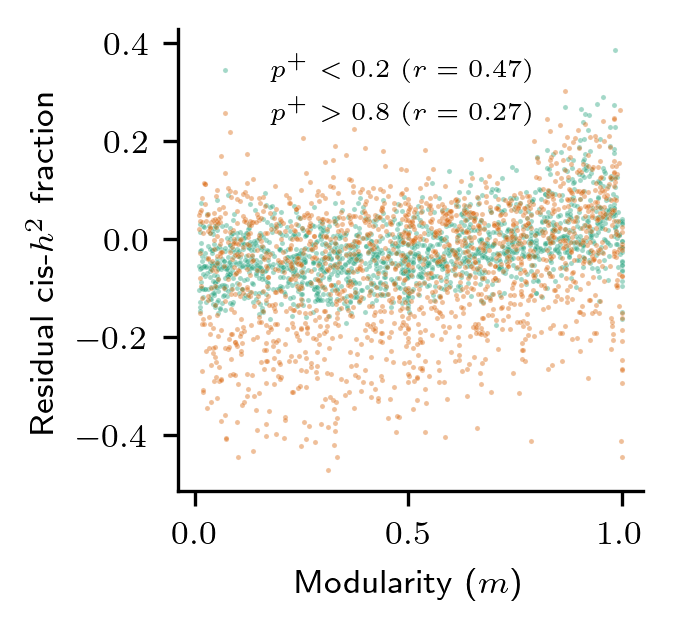

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300);

y = 'resid1'
x = 'm'
ix = grns['I(1 / (1 + (r * (gamma ** 2))))'] < 0.75

for label,ix2 in {
    r'$p^+ < 0.2$': grns['p_up'] < 0.2,
    r'$p^+ > 0.8$': grns['p_up'] > 0.8
}.items():
    sns.scatterplot(
        data = grns.loc[ix & ix2, :],
        y = y,
        x = x,
        s = 1.5,
        alpha = 0.4,
        label = ' '.join([label, '$(r ={:.2f})$'.format(ss.pearsonr(grns.loc[ix & ix2, y], grns.loc[ix & ix2, x])[0])]),
        ax = ax
    );

ax.legend(frameon=False, fontsize=6);
ax.set_xlabel('Modularity ({})'.format(r'$m$'));
ax.set_ylabel('Residual cis-{} fraction'.format(r'$h^2$'));
sns.despine();